## First Attempt

In [3]:
# %% DIFFERENT APPROACH - Vision Transformer + Transformer Decoder (TrOCR-style)
# ====================== Setup / Installs ======================
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

DRIVE_BASE = "/content/drive/MyDrive/Full_Dataset/Full_Dataset"
LOCAL_BASE = "/content/dataset"
os.makedirs(LOCAL_BASE, exist_ok=True)

for set_name in ["Set1", "Set2", "Set3"]:
    zip_path = f"{DRIVE_BASE}/{set_name}.zip"
    extract_dir = f"{LOCAL_BASE}/{set_name}"
    if os.path.exists(zip_path) and not os.path.exists(extract_dir):
        print(f"Extracting {set_name}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(LOCAL_BASE)
        print(f"  ✓ {set_name} extracted")
    elif os.path.exists(extract_dir):
        print(f"  ✓ {set_name} already extracted")
    else:
        print(f"  ⚠ {zip_path} not found")

!pip -q install albumentations==1.4.7 editdistance==0.8.1 tqdm timm

# ====================== Imports ======================
import time, random, unicodedata, warnings, math, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import albumentations as A
import timm

warnings.filterwarnings("ignore")
cv2.setNumThreads(0)

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

def human(n): return f"{n:,}"
def autocast_ctx(): return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        return f"GPU: {a:.2f}/{r:.2f}GB"
    return "CPU"

# ====================== Data Loading ======================
LOCAL_BASE = Path("/content/dataset")
CSV_PATH = Path("/content/drive/MyDrive/Full_Dataset/Full_Dataset/labels_fixed.csv")
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
assert {'img_name', 'label', 'class'}.issubset(df.columns)

def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df['label'] = df['label'].astype(str).apply(normalize_label)

def get_img_path(img_name):
    for set_num in [1, 2, 3]:
        prefix = f"Set{set_num}_"
        if img_name.startswith(prefix):
            actual_name = img_name[len(prefix):]
            return str(LOCAL_BASE / f"Set{set_num}" / "images" / actual_name)
    for set_num in [1, 2, 3]:
        path = LOCAL_BASE / f"Set{set_num}" / "images" / img_name
        if path.exists():
            return str(path)
    return None

df['img_path'] = df['img_name'].apply(get_img_path)
df = df[df['img_path'].apply(lambda p: p is not None and Path(p).exists())].reset_index(drop=True)
print(f"Images found: {human(len(df))}")

# ====================== Special Tokens & Charset ======================
# For seq2seq, we need: <PAD>, <SOS>, <EOS>, and character tokens
PAD_TOKEN = '<PAD>'
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'

char_counts = Counter()
for s in df['label']:
    for ch in s:
        char_counts[ch] += 1

# Build vocabulary: special tokens first, then characters by frequency
special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
char_tokens = sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
vocab = special_tokens + char_tokens

char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}

PAD_IDX = char2idx[PAD_TOKEN]
SOS_IDX = char2idx[SOS_TOKEN]
EOS_IDX = char2idx[EOS_TOKEN]
UNK_IDX = char2idx[UNK_TOKEN]
VOCAB_SIZE = len(vocab)

print(f"Vocabulary size: {VOCAB_SIZE} (incl. special tokens)")

# ====================== Style Classes ======================
style_names = sorted(df['class'].fillna("Unknown").unique().tolist())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}
NUM_STYLES = len(style_names)
print(f"Styles ({NUM_STYLES}): {style_names}")

# ====================== Encode/Decode Functions ======================
RTL_REVERSE = True
MAX_SEQ_LEN = 64  # Maximum output sequence length

def encode_label(text, rtl_reverse=RTL_REVERSE):
    """Encode text to token indices (with SOS/EOS)."""
    if rtl_reverse:
        text = text[::-1]
    ids = [SOS_IDX] + [char2idx.get(ch, UNK_IDX) for ch in text] + [EOS_IDX]
    return ids[:MAX_SEQ_LEN]  # Truncate if too long

def decode_tokens(indices, rtl_reverse=RTL_REVERSE):
    """Decode token indices back to text."""
    chars = []
    for idx in indices:
        if idx == EOS_IDX:
            break
        if idx not in [PAD_IDX, SOS_IDX, UNK_IDX]:
            chars.append(idx2char.get(idx, ''))
    text = ''.join(chars)
    return text[::-1] if rtl_reverse else text

# Filter empty labels
df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
df = df[df['enc_len'] > 2].reset_index(drop=True)  # At least SOS + 1 char + EOS
print(f"After filtering: {human(len(df))} samples")

# ====================== Train/Val/Test Split ======================
train_df, test_df = train_test_split(df, test_size=0.10, random_state=SEED, stratify=df['class'])
train_df, val_df = train_test_split(train_df, test_size=0.1111, random_state=SEED, stratify=train_df['class'])
print(f"Train: {human(len(train_df))} | Val: {human(len(val_df))} | Test: {human(len(test_df))}")

# ====================== Class Balancing ======================
train_class_counts = train_df['class'].value_counts()
median_count = train_class_counts.median()
class_weights = {}
for cls, count in train_class_counts.items():
    weight = np.sqrt(median_count / count)
    weight = np.clip(weight, 1.0, 8.0)
    class_weights[cls] = weight

sample_weights = train_df['class'].map(class_weights).values
sample_weights = torch.DoubleTensor(sample_weights)
effective_total = int(sum(count * class_weights[cls] for cls, count in train_class_counts.items()))
print(f"Effective samples/epoch: {effective_total}")

# ====================== Image Processing ======================
IMG_HEIGHT = 64
IMG_WIDTH = 384  # Fixed width for ViT patches
MEAN, STD = 0.5, 0.5
PATCH_SIZE = 16  # ViT patch size

def load_and_preprocess(img_path, target_h=IMG_HEIGHT, target_w=IMG_WIDTH):
    """Load image, resize maintaining aspect ratio, pad to fixed size."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = np.ones((target_h, target_w), dtype=np.uint8) * 255

    h, w = img.shape
    # Scale to target height
    scale = target_h / h
    new_w = int(w * scale)
    new_w = min(new_w, target_w)

    img = cv2.resize(img, (new_w, target_h), interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC)

    # Pad to target width
    if new_w < target_w:
        pad_w = target_w - new_w
        img = cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=255)

    return img

# ====================== Augmentations ======================
AUG_P = 0.35

train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P * 0.8),
    A.Perspective(scale=(0.02, 0.05), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=2, border_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P * 0.8),
    A.GaussianBlur(blur_limit=(3, 5), p=AUG_P * 0.4),
])

def apply_aug(img):
    return train_aug(image=img)["image"]

# ====================== Dataset ======================
class OCRSeq2SeqDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, training=True):
        self.df = frame.reset_index(drop=True)
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]

        # Load and preprocess image
        img = load_and_preprocess(row['img_path'], IMG_HEIGHT, IMG_WIDTH)

        if self.training:
            img = apply_aug(img)

        # Normalize
        img = img.astype(np.float32) / 255.0
        img = (img - MEAN) / STD

        # Convert to tensor (C, H, W)
        img_t = torch.from_numpy(img).unsqueeze(0)

        # Encode label
        label_ids = encode_label(row['label'], RTL_REVERSE)
        label_t = torch.tensor(label_ids, dtype=torch.long)

        # Style
        style_idx = style2idx[row['class']]

        return img_t, label_t, row['label'], style_idx

def collate_fn(batch):
    imgs, labels, label_strs, style_idxs = zip(*batch)

    # Stack images (all same size now)
    imgs = torch.stack(imgs, dim=0)

    # Pad labels to same length
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=PAD_IDX)

    style_idxs = torch.tensor(style_idxs, dtype=torch.long)

    return imgs, labels_padded, label_lens, label_strs, style_idxs

# ====================== Vision Transformer Encoder ======================
class PatchEmbedding(nn.Module):
    """Convert image to patch embeddings."""
    def __init__(self, img_h=64, img_w=384, patch_size=16, in_chans=1, embed_dim=384):
        super().__init__()
        self.img_h = img_h
        self.img_w = img_w
        self.patch_size = patch_size
        self.n_patches_h = img_h // patch_size
        self.n_patches_w = img_w // patch_size
        self.n_patches = self.n_patches_h * self.n_patches_w

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, 1, H, W)
        x = self.proj(x)  # (B, embed_dim, n_patches_h, n_patches_w)
        x = x.flatten(2).transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class ViTEncoder(nn.Module):
    """Vision Transformer Encoder."""
    def __init__(self, img_h=64, img_w=384, patch_size=16, in_chans=1,
                 embed_dim=384, depth=6, num_heads=6, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_h, img_w, patch_size, in_chans, embed_dim)
        n_patches = self.patch_embed.n_patches

        # Learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)

        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        # x: (B, 1, H, W)
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.encoder(x)
        x = self.norm(x)
        return x  # (B, n_patches, embed_dim)

# ====================== Transformer Decoder ======================
class TransformerDecoder(nn.Module):
    """Transformer Decoder for autoregressive text generation."""
    def __init__(self, vocab_size, embed_dim=384, depth=4, num_heads=6,
                 mlp_ratio=4.0, dropout=0.1, max_seq_len=64):
        super().__init__()

        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len

        # Token embeddings
        self.token_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))
        self.embed_drop = nn.Dropout(dropout)

        # Transformer decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)

        # Output projection
        self.output_proj = nn.Linear(embed_dim, vocab_size)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        """
        tgt: (B, T) token indices
        memory: (B, S, embed_dim) encoder output
        """
        B, T = tgt.shape

        # Embeddings
        x = self.token_embed(tgt)  # (B, T, embed_dim)
        x = x + self.pos_embed[:, :T, :]
        x = self.embed_drop(x)

        # Generate causal mask
        if tgt_mask is None:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(T, device=tgt.device)

        # Decode
        x = self.decoder(x, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        x = self.norm(x)

        # Project to vocabulary
        logits = self.output_proj(x)  # (B, T, vocab_size)
        return logits

# ====================== Full Model ======================
class VisionTransformerOCR(nn.Module):
    """
    TrOCR-style model:
    - ViT Encoder for image features
    - Transformer Decoder for autoregressive text generation
    - Style classification head
    """
    def __init__(self, vocab_size, num_styles, img_h=64, img_w=384, patch_size=16,
                 embed_dim=384, enc_depth=6, dec_depth=4, num_heads=6,
                 mlp_ratio=4.0, dropout=0.1, max_seq_len=64):
        super().__init__()

        self.encoder = ViTEncoder(
            img_h=img_h, img_w=img_w, patch_size=patch_size, in_chans=1,
            embed_dim=embed_dim, depth=enc_depth, num_heads=num_heads,
            mlp_ratio=mlp_ratio, dropout=dropout
        )

        self.decoder = TransformerDecoder(
            vocab_size=vocab_size, embed_dim=embed_dim, depth=dec_depth,
            num_heads=num_heads, mlp_ratio=mlp_ratio, dropout=dropout,
            max_seq_len=max_seq_len
        )

        # Style classification head (from encoder features)
        self.style_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_styles)
        )

        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len

    def forward(self, imgs, tgt_ids=None, tgt_padding_mask=None):
        """
        imgs: (B, 1, H, W)
        tgt_ids: (B, T) target token indices (for teacher forcing)
        """
        # Encode image
        memory = self.encoder(imgs)  # (B, n_patches, embed_dim)

        # Style classification (mean pooling of encoder features)
        style_logits = self.style_head(memory.mean(dim=1))

        if tgt_ids is not None:
            # Teacher forcing: use ground truth tokens
            logits = self.decoder(tgt_ids, memory, tgt_key_padding_mask=tgt_padding_mask)
            return logits, style_logits
        else:
            return memory, style_logits

    @torch.no_grad()
    def generate(self, imgs, max_len=None, temperature=1.0):
        """Autoregressive generation."""
        if max_len is None:
            max_len = self.max_seq_len

        B = imgs.size(0)
        device = imgs.device

        # Encode
        memory = self.encoder(imgs)

        # Start with SOS token
        generated = torch.full((B, 1), SOS_IDX, dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            logits = self.decoder(generated, memory)
            next_logits = logits[:, -1, :] / temperature

            # Greedy decoding
            next_token = next_logits.argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)

            # Stop if all sequences have generated EOS
            if (next_token == EOS_IDX).all():
                break

        return generated

# ====================== Training Configuration ======================
BATCH_SIZE = 48  # Smaller batch for transformer (more memory)
EPOCHS = 100
LR = 3e-4
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 5
LABEL_SMOOTHING = 0.1
LAMBDA_STYLE = 0.15

sampler = WeightedRandomSampler(sample_weights, num_samples=effective_total, replacement=True)

# ====================== Dataloaders ======================
train_ds = OCRSeq2SeqDataset(train_df, training=True)
val_ds = OCRSeq2SeqDataset(val_df, training=False)
test_ds = OCRSeq2SeqDataset(test_df, training=False)

NUM_WORKERS = 4
loader_kwargs = dict(collate_fn=collate_fn, pin_memory=True, num_workers=NUM_WORKERS, persistent_workers=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, **loader_kwargs)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)

print(f"\nTrain loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")

# ====================== Model ======================
print("\n" + "="*60)
print("MODEL ARCHITECTURE - Vision Transformer OCR")
print("="*60)

model = VisionTransformerOCR(
    vocab_size=VOCAB_SIZE,
    num_styles=NUM_STYLES,
    img_h=IMG_HEIGHT,
    img_w=IMG_WIDTH,
    patch_size=PATCH_SIZE,
    embed_dim=384,
    enc_depth=6,
    dec_depth=4,
    num_heads=6,
    mlp_ratio=4.0,
    dropout=0.1,
    max_seq_len=MAX_SEQ_LEN
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {human(total_params)}")

# ====================== Loss & Optimizer ======================
ce_loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=LABEL_SMOOTHING)
style_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.98))

# Cosine annealing with warmup
def get_lr(epoch):
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / WARMUP_EPOCHS
    else:
        progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, get_lr)
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE == "cuda"))

# ====================== Metrics ======================
def cer(ref, hyp):
    return 0.0 if (len(ref) == 0 and len(hyp) == 0) else editdistance.eval(ref, hyp) / max(1, len(ref))

def wer(ref, hyp):
    r, h = ref.split(), hyp.split()
    return 0.0 if (len(r) == 0 and len(h) == 0) else editdistance.eval(r, h) / max(1, len(r))

# ====================== Evaluation ======================
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    tot_loss = tot_cer = tot_wer = 0.0
    cnt = 0
    cls_correct = cls_total = 0

    for imgs, labels, label_lens, label_strs, style_idxs in loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        B = imgs.size(0)

        # Create padding mask (True where padded)
        tgt_padding_mask = (labels == PAD_IDX)

        with autocast_ctx():
            # Teacher forcing forward pass for loss
            logits, style_logits = model(imgs, labels[:, :-1], tgt_padding_mask[:, :-1])

            # Compute loss (shift targets by 1)
            loss_ce = ce_loss_fn(logits.reshape(-1, VOCAB_SIZE), labels[:, 1:].reshape(-1))
            loss_style = style_loss_fn(style_logits, style_idxs)
            loss = loss_ce + LAMBDA_STYLE * loss_style

        tot_loss += loss.item() * B
        cnt += B

        # Generate predictions
        generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
        preds = [decode_tokens(gen.tolist()) for gen in generated]

        for gt, pr in zip(label_strs, preds):
            tot_cer += cer(gt, pr)
            tot_wer += wer(gt, pr)

        # Style accuracy
        pred_style = style_logits.argmax(dim=1)
        cls_correct += (pred_style == style_idxs).sum().item()
        cls_total += B

    return {
        "loss": tot_loss / cnt if cnt else None,
        "cer": tot_cer / cnt if cnt else None,
        "wer": tot_wer / cnt if cnt else None,
        "style_acc": cls_correct / cls_total if cls_total > 0 else None
    }

# ====================== Training Loop ======================
print("\n" + "="*60)
print("TRAINING - Vision Transformer OCR")
print("="*60)

SAVE_DIR = Path("./checkpoints_vit")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "vit_ocr_best.pt"

history = {"train_loss": [], "val_loss": [], "val_cer": [], "val_wer": [], "val_style_acc": []}
best_cer = float('inf')

print(f"\n[Training] Epochs={EPOCHS}, Batch={BATCH_SIZE}, LR={LR}")
print(f"Device: {DEVICE} | {gpu_mem()}\n")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    seen = 0
    t0 = time.time()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch:03d}", leave=False)
    for bidx, (imgs, labels, label_lens, label_strs, style_idxs) in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        # Create padding mask
        tgt_padding_mask = (labels == PAD_IDX)

        optimizer.zero_grad(set_to_none=True)

        with autocast_ctx():
            # Teacher forcing: input is labels[:-1], target is labels[1:]
            logits, style_logits = model(imgs, labels[:, :-1], tgt_padding_mask[:, :-1])

            loss_ce = ce_loss_fn(logits.reshape(-1, VOCAB_SIZE), labels[:, 1:].reshape(-1))
            loss_style = style_loss_fn(style_logits, style_idxs)
            loss = loss_ce + LAMBDA_STYLE * loss_style

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(loss=f"{loss.item():.3f}", avg=f"{running/max(1,seen):.3f}")

    scheduler.step()
    train_loss = running / max(1, seen)
    history["train_loss"].append(train_loss)

    # Validation
    val_metrics = evaluate(model, val_loader)
    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

    dt = time.time() - t0
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:03d}/{EPOCHS} | train={train_loss:.3f} | "
          f"val: CER={val_metrics['cer']:.4f} WER={val_metrics['wer']:.4f} style={val_metrics['style_acc']:.3f} | "
          f"lr={current_lr:.2e} | {dt:.1f}s | {gpu_mem()}")

    # Save best model
    if val_metrics["cer"] is not None and val_metrics["cer"] < best_cer:
        best_cer = val_metrics["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "vocab": vocab,
            "char2idx": char2idx,
            "style_names": style_names,
            "config": {
                "IMG_HEIGHT": IMG_HEIGHT, "IMG_WIDTH": IMG_WIDTH,
                "RTL_REVERSE": RTL_REVERSE, "MAX_SEQ_LEN": MAX_SEQ_LEN
            },
            "metrics": val_metrics
        }, BEST_PATH)
        print(f"  ✓ New best CER={best_cer:.4f} saved")

    # Memory cleanup
    if epoch % 10 == 0:
        gc.collect()
        torch.cuda.empty_cache()

print(f"\n[Training] Complete! Best CER: {best_cer:.4f}")

# ====================== Training Curves ======================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss"); axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer"], label="Val CER")
axes[0, 1].set_title("Character Error Rate"); axes[0, 1].legend(); axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer"], label="Val WER")
axes[1, 0].set_title("Word Error Rate"); axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc"], label="Style Acc")
axes[1, 1].set_title("Style Accuracy"); axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(SAVE_DIR / "training_curves.png", dpi=150)
plt.show()

# ====================== Test Evaluation ======================
print("\n" + "="*60)
print("TEST EVALUATION")
print("="*60)

ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

test_metrics = evaluate(model, test_loader)
print(f"\nTEST — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | Style={test_metrics['style_acc']:.4f}")

# ====================== Qualitative Samples ======================
@torch.no_grad()
def show_samples(model, loader, k=8):
    model.eval()
    imgs, labels, label_lens, label_strs, style_idxs = next(iter(loader))
    imgs = imgs.to(DEVICE)

    generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
    preds = [decode_tokens(gen.tolist()) for gen in generated]

    _, style_logits = model(imgs, labels[:, :-1].to(DEVICE))
    style_pred = style_logits.argmax(1).cpu().tolist()

    fig, axes = plt.subplots(min(k, len(imgs)), 1, figsize=(14, 3*min(k, len(imgs))))
    if k == 1:
        axes = [axes]

    for i in range(min(k, len(imgs))):
        im = imgs[i, 0].cpu().numpy()
        im = np.clip(im * STD + MEAN, 0, 1)

        gt_text = label_strs[i]
        pr_text = preds[i]
        match = "✓" if gt_text == pr_text else "✗"

        axes[i].imshow(im, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"GT: {gt_text}\nPR: {pr_text} {match}", fontsize=10)

    plt.tight_layout()
    plt.savefig(SAVE_DIR / "vit_samples.png", dpi=150)
    plt.show()

show_samples(model, test_loader, k=8)

# ====================== Final Summary ======================
print("\n" + "="*60)
print("FINAL SUMMARY - Vision Transformer OCR")
print("="*60)
print(f"Architecture: ViT Encoder (6 layers) + Transformer Decoder (4 layers)")
print(f"Embed dim: 384, Heads: 6, Patch size: {PATCH_SIZE}")
print(f"Total parameters: {human(total_params)}")
print(f"\nBest Validation CER: {best_cer:.4f}")
print(f"\nTest Metrics:")
print(f"  - CER: {test_metrics['cer']:.4f}")
print(f"  - WER: {test_metrics['wer']:.4f}")
print(f"  - Style Accuracy: {test_metrics['style_acc']:.4f}")
print(f"\nCheckpoints: {SAVE_DIR}")
print("✅ ViT-OCR Complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting Set1...
  ✓ Set1 extracted
Extracting Set2...


KeyboardInterrupt: 

## V2

In [1]:
"""
================================================================================
DECEMBER RUNS - ViT-CTC HYBRID (Optimized for T4 GPU)
================================================================================
Key changes from previous ViT attempt:
1. ViT encoder + CTC decoder (NOT autoregressive - much better for OCR)
2. Larger model and batch size to utilize T4's 15GB
3. Hybrid CNN-ViT: Use CNN for patch extraction (better for OCR)
4. Data augmentation + class balancing (proven to work)
================================================================================
"""

# ============================================================================
# CELL 1: SETUP & DEPENDENCIES
# ============================================================================

import subprocess
import sys

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Extract datasets
import zipfile
import os

DRIVE_BASE = "/content/drive/MyDrive/Full_Dataset/Full_Dataset"
LOCAL_BASE = "/content/dataset"
os.makedirs(LOCAL_BASE, exist_ok=True)

for set_name in ["Set1", "Set2", "Set3"]:
    zip_path = f"{DRIVE_BASE}/{set_name}.zip"
    extract_dir = f"{LOCAL_BASE}/{set_name}"
    if os.path.exists(zip_path) and not os.path.exists(extract_dir):
        print(f"Extracting {set_name}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(LOCAL_BASE)
        print(f"  ✓ {set_name} extracted")
    else:
        if os.path.exists(extract_dir):
            print(f"  ✓ {set_name} already extracted")
        else:
            print(f"  ⚠ {zip_path} not found")

# Install dependencies
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "editdistance"])

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import editdistance
import math
import random
import warnings
import gc
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION - Optimized for T4 GPU (15GB)
# ============================================================================

class Config:
    # Data
    IMG_HEIGHT = 64
    IMG_WIDTH = 512
    MAX_LABEL_LEN = 64

    # Model - Hybrid CNN-ViT
    PATCH_SIZE = 8           # Smaller patches for better detail
    EMBED_DIM = 512          # Larger embedding
    NUM_HEADS = 8
    VIT_DEPTH = 8            # Deeper transformer
    MLP_RATIO = 4.0
    DROPOUT = 0.1

    # CTC Decoder
    LSTM_HIDDEN = 384
    LSTM_LAYERS = 2

    # Training - Utilize T4 GPU
    BATCH_SIZE = 96          # Much larger batch for T4
    EPOCHS = 100
    LR = 4e-4
    WARMUP_EPOCHS = 5
    WEIGHT_DECAY = 0.05

    # Class balancing
    MAX_WEIGHT_RATIO = 10.0

    # Paths - MATCHING CELL 7!
    LOCAL_BASE = "/content/dataset"
    LABELS_CSV = "/content/drive/MyDrive/Full_Dataset/Full_Dataset/labels_fixed.csv"
    SAVE_PATH = "/content/drive/MyDrive/Full_Dataset/Full_Dataset/vit_ctc_best.pt"

CFG = Config()

# ============================================================================
# DEVICE SETUP
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"Total VRAM: {gpu_mem:.1f} GB")

# ============================================================================
# VOCABULARY
# ============================================================================

class ArabicVocab:
    def __init__(self):
        self.PAD = 0
        self.BLANK = 1  # CTC blank

        # Arabic characters
        arabic_chars = (
            'ءآأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىي'
            'ًٌٍَُِّْ'
            ' '
        )

        self.char2idx = {c: i + 2 for i, c in enumerate(arabic_chars)}
        self.idx2char = {i + 2: c for i, c in enumerate(arabic_chars)}
        self.idx2char[self.PAD] = ''
        self.idx2char[self.BLANK] = ''

        self.vocab_size = len(arabic_chars) + 2

    def encode(self, text, max_len=None):
        indices = [self.char2idx.get(c, self.PAD) for c in text]
        if max_len:
            indices = indices[:max_len]
            indices += [self.PAD] * (max_len - len(indices))
        return indices

    def decode(self, indices, remove_blanks=True):
        chars = []
        prev_idx = None
        for idx in indices:
            if idx == self.PAD:
                continue
            if remove_blanks and idx == self.BLANK:
                prev_idx = idx
                continue
            if idx != prev_idx:
                char = self.idx2char.get(idx, '')
                if char:
                    chars.append(char)
            prev_idx = idx
        return ''.join(chars)

vocab = ArabicVocab()
print(f"Vocabulary size: {vocab.vocab_size}")

# ============================================================================
# DATASET WITH AUGMENTATION
# ============================================================================

class ArabicOCRDataset(Dataset):
    def __init__(self, df, style2idx, vocab, augment=False):
        self.df = df.reset_index(drop=True)
        self.style2idx = style2idx
        self.vocab = vocab
        self.augment = augment

        # Augmentation transforms
        self.color_jitter = T.ColorJitter(
            brightness=0.3, contrast=0.3, saturation=0.2
        )

    def __len__(self):
        return len(self.df)

    def load_and_preprocess(self, img_path):
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img = Image.new('RGB', (CFG.IMG_WIDTH, CFG.IMG_HEIGHT), (255, 255, 255))

        # Resize maintaining aspect ratio
        w, h = img.size
        target_h = CFG.IMG_HEIGHT
        target_w = CFG.IMG_WIDTH

        scale = target_h / h
        new_w = min(int(w * scale), target_w)
        new_h = target_h

        img = img.resize((new_w, new_h), Image.BILINEAR)

        # Pad to target width (right padding for RTL)
        padded = Image.new('RGB', (target_w, target_h), (255, 255, 255))
        padded.paste(img, (target_w - new_w, 0))  # Right-align for Arabic

        return padded

    def augment_image(self, img):
        # Random rotation
        if random.random() < 0.3:
            angle = random.uniform(-3, 3)
            img = TF.rotate(img, angle, fill=255)

        # Color jitter
        if random.random() < 0.5:
            img = self.color_jitter(img)

        # Random erasing (simulate noise/damage)
        if random.random() < 0.2:
            img_tensor = TF.to_tensor(img)
            h, w = img_tensor.shape[1:]
            # Erase small random rectangle
            eh = random.randint(2, 8)
            ew = random.randint(5, 30)
            ey = random.randint(0, h - eh)
            ex = random.randint(0, w - ew)
            img_tensor[:, ey:ey+eh, ex:ex+ew] = 1.0
            img = TF.to_pil_image(img_tensor)

        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img = self.load_and_preprocess(row['img_path'])

        # Augment if training
        if self.augment:
            img = self.augment_image(img)

        # To tensor and normalize
        img_tensor = TF.to_tensor(img)
        img_tensor = TF.normalize(img_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        # Encode label
        label_text = str(row['label']) if pd.notna(row['label']) else ''
        label_indices = self.vocab.encode(label_text, CFG.MAX_LABEL_LEN)
        label_len = min(len(label_text), CFG.MAX_LABEL_LEN)

        # Style (column is named 'class' in CSV)
        style_idx = self.style2idx.get(row['class'], 0)

        return {
            'image': img_tensor,
            'label': torch.tensor(label_indices, dtype=torch.long),
            'label_len': torch.tensor(label_len, dtype=torch.long),
            'style': torch.tensor(style_idx, dtype=torch.long),
            'text': label_text
        }

# ============================================================================
# HYBRID CNN-ViT MODEL WITH CTC
# ============================================================================

class ConvPatchEmbed(nn.Module):
    """CNN-based patch embedding - better for OCR than linear projection"""
    def __init__(self, in_channels=3, embed_dim=512, patch_size=8):
        super().__init__()
        # Multi-stage CNN for patch extraction
        self.conv = nn.Sequential(
            # Stage 1: 64 -> 32
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            # Stage 2: 32 -> 16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            # Stage 3: 16 -> 8
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)),  # Height only

            # Stage 4: 8 -> 4
            nn.Conv2d(256, embed_dim, 3, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)),  # Height only

            # Final: 4 -> 1
            nn.Conv2d(embed_dim, embed_dim, (4, 1)),  # Collapse height
        )

    def forward(self, x):
        # x: (B, 3, 64, 512)
        x = self.conv(x)  # (B, embed_dim, 1, W')
        x = x.squeeze(2)  # (B, embed_dim, W')
        x = x.permute(0, 2, 1)  # (B, W', embed_dim) = (B, seq_len, embed_dim)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, embed_dim),
            nn.Dropout(dropout)
        )

        self.drop_path = nn.Dropout(dropout)

    def forward(self, x):
        # Pre-norm architecture
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.drop_path(attn_out)

        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class ViTEncoder(nn.Module):
    def __init__(self, embed_dim=512, depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1, max_seq_len=128):
        super().__init__()

        # Learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        # Initialize position embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        B, T, C = x.shape

        # Add positional embeddings
        x = x + self.pos_embed[:, :T, :]
        x = self.pos_drop(x)

        # Apply transformer layers
        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        return x

class CTCDecoder(nn.Module):
    """BiLSTM + Linear for CTC decoding"""
    def __init__(self, input_dim, hidden_dim, num_layers, vocab_size, dropout=0.1):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

class ViT_CTC_OCR(nn.Module):
    def __init__(self, vocab_size, num_styles, cfg):
        super().__init__()

        # CNN patch embedding
        self.patch_embed = ConvPatchEmbed(
            in_channels=3,
            embed_dim=cfg.EMBED_DIM,
            patch_size=cfg.PATCH_SIZE
        )

        # ViT encoder
        self.vit = ViTEncoder(
            embed_dim=cfg.EMBED_DIM,
            depth=cfg.VIT_DEPTH,
            num_heads=cfg.NUM_HEADS,
            mlp_ratio=cfg.MLP_RATIO,
            dropout=cfg.DROPOUT,
            max_seq_len=cfg.IMG_WIDTH // 4  # After CNN downsampling
        )

        # CTC decoder
        self.ctc_decoder = CTCDecoder(
            input_dim=cfg.EMBED_DIM,
            hidden_dim=cfg.LSTM_HIDDEN,
            num_layers=cfg.LSTM_LAYERS,
            vocab_size=vocab_size,
            dropout=cfg.DROPOUT
        )

        # Style classifier (from pooled features)
        self.style_head = nn.Sequential(
            nn.Linear(cfg.EMBED_DIM, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_styles)
        )

    def forward(self, x):
        # CNN patch embedding
        x = self.patch_embed(x)  # (B, T, embed_dim)

        # ViT encoding
        x = self.vit(x)  # (B, T, embed_dim)

        # CTC logits
        ctc_logits = self.ctc_decoder(x)  # (B, T, vocab_size)

        # Style classification (mean pooling)
        pooled = x.mean(dim=1)  # (B, embed_dim)
        style_logits = self.style_head(pooled)

        return ctc_logits, style_logits

# ============================================================================
# METRICS
# ============================================================================

def calculate_cer(pred, target):
    if len(target) == 0:
        return 1.0 if len(pred) > 0 else 0.0
    return editdistance.eval(pred, target) / len(target)

def calculate_wer(pred, target):
    pred_words = pred.split()
    target_words = target.split()
    if len(target_words) == 0:
        return 1.0 if len(pred_words) > 0 else 0.0
    return editdistance.eval(pred_words, target_words) / len(target_words)

def ctc_greedy_decode(logits, vocab):
    """Greedy CTC decoding"""
    # logits: (B, T, vocab_size)
    preds = logits.argmax(dim=-1)  # (B, T)

    decoded = []
    for pred in preds:
        decoded.append(vocab.decode(pred.cpu().tolist(), remove_blanks=True))

    return decoded

# ============================================================================
# DATA LOADING - MATCHING CELL 7 LOGIC!
# ============================================================================

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

# Load labels
df = pd.read_csv(CFG.LABELS_CSV)
print(f"CSV columns: {df.columns.tolist()}")

# Verify required columns exist
assert {'img_name', 'label', 'class'}.issubset(df.columns), f"Missing columns. Found: {df.columns.tolist()}"

# Build image paths based on Set prefix in img_name (MATCHING CELL 7!)
LOCAL_BASE_PATH = Path(CFG.LOCAL_BASE)

def get_img_path(img_name):
    """
    Image names are prefixed with Set number: Set1_001_segment_no_0.jpg
    We need to strip the prefix and look in Set{n}/images/ folder
    """
    for set_num in [1, 2, 3]:
        prefix = f"Set{set_num}_"
        if img_name.startswith(prefix):
            actual_name = img_name[len(prefix):]
            path = LOCAL_BASE_PATH / f"Set{set_num}" / "images" / actual_name
            if path.exists():
                return str(path)
    # Fallback: try without prefix
    for set_num in [1, 2, 3]:
        path = LOCAL_BASE_PATH / f"Set{set_num}" / "images" / img_name
        if path.exists():
            return str(path)
    return None

df['img_path'] = df['img_name'].apply(get_img_path)

# Filter to only existing images
before_filter = len(df)
df = df[df['img_path'].apply(lambda p: p is not None and Path(p).exists())].reset_index(drop=True)
print(f"Images found: {len(df):,} / {before_filter:,} ({100*len(df)/before_filter:.1f}%)")

# Filter by label length
df = df[df['label'].apply(lambda x: 0 < len(str(x)) <= CFG.MAX_LABEL_LEN)].copy()
print(f"After filtering: {len(df):,} samples")

# Style mapping (column is 'class' in CSV)
styles = sorted(df['class'].fillna("Unknown").unique().tolist())
style2idx = {s: i for i, s in enumerate(styles)}
idx2style = {i: s for s, i in style2idx.items()}
num_styles = len(styles)
print(f"Styles ({num_styles}): {styles}")

# Print class distribution
print("\nClass distribution:")
style_counts = df['class'].value_counts()
for style, count in style_counts.items():
    print(f"  {style}: {count}")

# ============================================================================
# TRAIN/VAL/TEST SPLIT
# ============================================================================

from sklearn.model_selection import train_test_split

# Stratified split (use 'class' column)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print(f"\nTrain: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

# ============================================================================
# WEIGHTED SAMPLER FOR CLASS IMBALANCE
# ============================================================================

style_counts_train = train_df['class'].value_counts()
max_count = style_counts_train.max()

# Sqrt-scaled weights (capped)
class_weights = {}
for style, count in style_counts_train.items():
    raw_weight = np.sqrt(max_count / count)
    class_weights[style] = min(raw_weight, CFG.MAX_WEIGHT_RATIO)

sample_weights = train_df['class'].map(class_weights).values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

print(f"\nClass weights (sqrt-scaled, capped at {CFG.MAX_WEIGHT_RATIO}x):")
for style, weight in sorted(class_weights.items(), key=lambda x: -x[1]):
    print(f"  {style}: {weight:.2f}x")

# ============================================================================
# CREATE DATALOADERS
# ============================================================================

train_ds = ArabicOCRDataset(train_df, style2idx, vocab, augment=True)
val_ds = ArabicOCRDataset(val_df, style2idx, vocab, augment=False)
test_ds = ArabicOCRDataset(test_df, style2idx, vocab, augment=False)

# Larger batch size for T4
train_loader = DataLoader(
    train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler,
    num_workers=4, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_ds, batch_size=CFG.BATCH_SIZE * 2,
    num_workers=4, pin_memory=True, shuffle=False
)
test_loader = DataLoader(
    test_ds, batch_size=CFG.BATCH_SIZE * 2,
    num_workers=4, pin_memory=True, shuffle=False
)

print(f"\nTrain batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# ============================================================================
# CREATE MODEL
# ============================================================================

print("\n" + "="*60)
print("MODEL ARCHITECTURE - ViT-CTC Hybrid")
print("="*60)

model = ViT_CTC_OCR(
    vocab_size=vocab.vocab_size,
    num_styles=num_styles,
    cfg=CFG
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# ============================================================================
# LOSS FUNCTIONS & OPTIMIZER
# ============================================================================

ctc_loss_fn = nn.CTCLoss(blank=vocab.BLANK, zero_infinity=True, reduction='mean')
style_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG.LR,
    weight_decay=CFG.WEIGHT_DECAY,
    betas=(0.9, 0.98)
)

# Cosine annealing with warmup
def lr_lambda(epoch):
    if epoch < CFG.WARMUP_EPOCHS:
        return (epoch + 1) / CFG.WARMUP_EPOCHS
    else:
        progress = (epoch - CFG.WARMUP_EPOCHS) / (CFG.EPOCHS - CFG.WARMUP_EPOCHS)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Mixed precision
scaler = GradScaler('cuda')

# ============================================================================
# TRAINING LOOP
# ============================================================================

print("\n" + "="*60)
print("TRAINING - ViT-CTC Hybrid")
print("="*60)

print(f"\n[Config] Epochs={CFG.EPOCHS}, Batch={CFG.BATCH_SIZE}, LR={CFG.LR}")
print(f"[Config] ViT Depth={CFG.VIT_DEPTH}, Embed={CFG.EMBED_DIM}, Heads={CFG.NUM_HEADS}")

best_cer = float('inf')
patience = 20
patience_counter = 0

for epoch in range(1, CFG.EPOCHS + 1):
    # ==================== TRAINING ====================
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        images = batch['image'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)
        label_lens = batch['label_len'].to(device, non_blocking=True)
        styles = batch['style'].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast('cuda', dtype=torch.float16):
            ctc_logits, style_logits = model(images)

            # CTC loss
            log_probs = F.log_softmax(ctc_logits, dim=-1)  # (B, T, V)
            log_probs = log_probs.permute(1, 0, 2)  # (T, B, V) for CTC

            B, T = ctc_logits.shape[:2]
            input_lens = torch.full((B,), T, dtype=torch.long, device=device)

            # Get actual label sequences (remove padding)
            ctc_loss = ctc_loss_fn(log_probs, labels, input_lens, label_lens)

            # Style loss
            style_loss = style_loss_fn(style_logits, styles)

            # Combined loss
            loss = ctc_loss + 0.3 * style_loss

        # Check for NaN
        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    scheduler.step()

    # ==================== VALIDATION ====================
    model.eval()
    all_preds, all_targets = [], []
    correct_styles = 0
    total_styles = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device, non_blocking=True)
            styles = batch['style'].to(device, non_blocking=True)
            texts = batch['text']

            with autocast('cuda', dtype=torch.float16):
                ctc_logits, style_logits = model(images)

            # Decode predictions
            preds = ctc_greedy_decode(ctc_logits, vocab)
            all_preds.extend(preds)
            all_targets.extend(texts)

            # Style accuracy
            pred_styles = style_logits.argmax(dim=-1)
            correct_styles += (pred_styles == styles).sum().item()
            total_styles += styles.size(0)

    # Calculate metrics
    val_cer = np.mean([calculate_cer(p, t) for p, t in zip(all_preds, all_targets)])
    val_wer = np.mean([calculate_wer(p, t) for p, t in zip(all_preds, all_targets)])
    val_style_acc = correct_styles / total_styles

    # GPU memory
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.max_memory_reserved() / 1e9
    else:
        allocated, reserved = 0, 0

    # Logging
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:03d}/{CFG.EPOCHS} | "
          f"train={train_loss:.4f} | "
          f"val: CER={val_cer:.4f} WER={val_wer:.4f} style={val_style_acc:.3f} | "
          f"lr={lr:.2e} | "
          f"GPU: {allocated:.1f}/{reserved:.1f}GB")

    # Save best model
    if val_cer < best_cer:
        best_cer = val_cer
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_cer': best_cer,
            'config': {
                'vocab_size': vocab.vocab_size,
                'num_styles': num_styles,
            }
        }, CFG.SAVE_PATH)
        print(f"  ✓ New best CER={best_cer:.4f} saved")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break

print(f"\n[Training Complete] Best CER: {best_cer:.4f}")

# ============================================================================
# TEST EVALUATION
# ============================================================================

print("\n" + "="*60)
print("TEST EVALUATION")
print("="*60)

# Load best model
checkpoint = torch.load(CFG.SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds, all_targets = [], []
correct_styles = 0
total_styles = 0
style_correct = {s: 0 for s in styles}
style_total = {s: 0 for s in styles}

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device, non_blocking=True)
        style_indices = batch['style'].to(device, non_blocking=True)
        texts = batch['text']

        with autocast('cuda', dtype=torch.float16):
            ctc_logits, style_logits = model(images)

        # Decode
        preds = ctc_greedy_decode(ctc_logits, vocab)
        all_preds.extend(preds)
        all_targets.extend(texts)

        # Style
        pred_styles = style_logits.argmax(dim=-1)
        correct_styles += (pred_styles == style_indices).sum().item()
        total_styles += style_indices.size(0)

        # Per-style accuracy
        for i, (ps, ts) in enumerate(zip(pred_styles.cpu().numpy(), style_indices.cpu().numpy())):
            style_name = idx2style[ts]
            style_total[style_name] += 1
            if ps == ts:
                style_correct[style_name] += 1

# Calculate final metrics
test_cer = np.mean([calculate_cer(p, t) for p, t in zip(all_preds, all_targets)])
test_wer = np.mean([calculate_wer(p, t) for p, t in zip(all_preds, all_targets)])
test_style_acc = correct_styles / total_styles

print(f"\nTEST RESULTS:")
print(f"  CER: {test_cer:.4f}")
print(f"  WER: {test_wer:.4f}")
print(f"  Style Accuracy: {test_style_acc:.4f}")

print(f"\nPer-Style Accuracy:")
for style in styles:
    if style_total[style] > 0:
        acc = style_correct[style] / style_total[style]
        print(f"  {style}: {acc:.4f} ({style_correct[style]}/{style_total[style]})")

# Sample predictions
print(f"\nSample Predictions:")
for i in range(min(10, len(all_preds))):
    print(f"  Target: {all_targets[i]}")
    print(f"  Pred:   {all_preds[i]}")
    cer = calculate_cer(all_preds[i], all_targets[i])
    print(f"  CER: {cer:.4f}")
    print()

# Cleanup
gc.collect()
torch.cuda.empty_cache()
print("\n✓ Done!")

Mounted at /content/drive
Extracting Set1...
  ✓ Set1 extracted
Extracting Set2...
  ✓ Set2 extracted
Extracting Set3...
  ✓ Set3 extracted
Device: cuda
GPU: NVIDIA L4
Total VRAM: 23.8 GB
Vocabulary size: 47

LOADING DATA
CSV columns: ['img_name', 'class', 'label']
Images found: 5,032 / 5,035 (99.9%)
After filtering: 4,807 samples
Styles (5): ['Diwani', 'Kufic', 'Muhaquaq', 'Naskh', 'Thuluth']

Class distribution:
  Naskh: 3670
  Thuluth: 916
  Diwani: 179
  Kufic: 25
  Muhaquaq: 17

Train: 3,845 | Val: 481 | Test: 481

Class weights (sqrt-scaled, capped at 10.0x):
  Kufic: 10.00x
  Muhaquaq: 10.00x
  Diwani: 4.53x
  Thuluth: 2.00x
  Naskh: 1.00x

Train batches: 40 | Val batches: 3

MODEL ARCHITECTURE - ViT-CTC Hybrid
Total parameters: 35,135,604
Trainable parameters: 35,135,604

TRAINING - ViT-CTC Hybrid

[Config] Epochs=100, Batch=96, LR=0.0004
[Config] ViT Depth=8, Embed=512, Heads=8
Epoch 001/100 | train=6.1796 | val: CER=1.0000 WER=1.0000 style=0.915 | lr=1.60e-04 | GPU: 0.6/12.7G

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## USING AUGMENTED DATA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  ✓ generated_data already extracted
Device: cuda
GPU: NVIDIA L4
Total VRAM: 23.8 GB
Images found: 9,913
Vocabulary size: 65 (incl. special tokens)
Styles (3): ['Diwani', 'Kufic', 'Thuluth']
After filtering: 9,913 samples
Train: 7,929 | Val: 992 | Test: 992
Effective samples/epoch: 8219

Train loader: 65 batches
Val loader: 8 batches

MODEL ARCHITECTURE - Vision Transformer OCR
Total parameters: 20,399,300

TRAINING - Vision Transformer OCR

[Training] Epochs=100, Batch=128, LR=0.0003
Device: cuda | GPU: 0.41/9.30GB



Epoch 001:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 001/100 | train=3.246 | val: CER=0.8501 WER=1.1357 style=0.651 | lr=1.20e-04 | 93.1s | GPU: 0.48/7.42GB
  ✓ New best CER=0.8501 saved


Epoch 002:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 002/100 | train=2.864 | val: CER=1.1753 WER=1.7304 style=0.888 | lr=1.80e-04 | 93.1s | GPU: 0.48/9.39GB


Epoch 003:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 003/100 | train=2.685 | val: CER=1.1003 WER=1.3452 style=0.941 | lr=2.40e-04 | 93.0s | GPU: 0.48/9.39GB


Epoch 004:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 004/100 | train=2.482 | val: CER=1.0281 WER=1.1386 style=0.936 | lr=3.00e-04 | 93.0s | GPU: 0.48/9.39GB


Epoch 005:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 005/100 | train=2.308 | val: CER=1.0985 WER=1.3842 style=0.976 | lr=3.00e-04 | 92.5s | GPU: 0.48/9.39GB


Epoch 006:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 006/100 | train=2.167 | val: CER=0.9815 WER=1.1969 style=0.993 | lr=3.00e-04 | 92.9s | GPU: 0.48/9.39GB


Epoch 007:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 007/100 | train=2.065 | val: CER=0.9499 WER=1.1641 style=0.975 | lr=3.00e-04 | 92.5s | GPU: 0.48/9.39GB


Epoch 008:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 008/100 | train=1.988 | val: CER=0.9805 WER=1.0792 style=0.995 | lr=2.99e-04 | 92.8s | GPU: 0.48/9.39GB


Epoch 009:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 009/100 | train=1.926 | val: CER=0.9847 WER=1.1606 style=0.985 | lr=2.99e-04 | 92.8s | GPU: 0.48/9.39GB


Epoch 010:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 010/100 | train=1.877 | val: CER=0.9268 WER=1.1261 style=0.997 | lr=2.98e-04 | 92.8s | GPU: 0.48/9.39GB


Epoch 011:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 011/100 | train=1.835 | val: CER=1.0537 WER=1.2515 style=0.997 | lr=2.97e-04 | 92.5s | GPU: 0.48/9.38GB


Epoch 012:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 012/100 | train=1.792 | val: CER=0.9793 WER=1.1589 style=0.987 | lr=2.96e-04 | 92.8s | GPU: 0.48/9.38GB


Epoch 013:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 013/100 | train=1.766 | val: CER=0.9047 WER=1.1132 style=0.996 | lr=2.95e-04 | 92.8s | GPU: 0.48/9.38GB


Epoch 014:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 014/100 | train=1.731 | val: CER=0.9302 WER=1.0981 style=0.997 | lr=2.93e-04 | 92.9s | GPU: 0.48/9.38GB


Epoch 015:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 015/100 | train=1.701 | val: CER=0.9727 WER=1.1518 style=0.996 | lr=2.92e-04 | 92.8s | GPU: 0.48/9.38GB


Epoch 016:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 016/100 | train=1.672 | val: CER=1.0239 WER=1.1514 style=0.984 | lr=2.90e-04 | 92.9s | GPU: 0.48/9.38GB


Epoch 017:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 017/100 | train=1.651 | val: CER=0.8646 WER=1.0558 style=0.997 | lr=2.88e-04 | 92.9s | GPU: 0.48/9.38GB


Epoch 018:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 018/100 | train=1.635 | val: CER=0.8484 WER=1.0483 style=0.994 | lr=2.86e-04 | 92.9s | GPU: 0.48/9.38GB
  ✓ New best CER=0.8484 saved


Epoch 019:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 019/100 | train=1.617 | val: CER=0.8391 WER=1.0565 style=0.994 | lr=2.84e-04 | 92.8s | GPU: 0.48/9.38GB
  ✓ New best CER=0.8391 saved


Epoch 020:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 020/100 | train=1.600 | val: CER=0.8224 WER=1.0226 style=0.997 | lr=2.82e-04 | 92.7s | GPU: 0.48/9.38GB
  ✓ New best CER=0.8224 saved


Epoch 021:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 021/100 | train=1.575 | val: CER=0.8592 WER=1.0488 style=0.998 | lr=2.79e-04 | 93.0s | GPU: 0.48/9.37GB


Epoch 022:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 022/100 | train=1.562 | val: CER=0.8706 WER=1.0443 style=0.999 | lr=2.77e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 023:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 023/100 | train=1.547 | val: CER=0.8596 WER=1.0345 style=0.998 | lr=2.74e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 024:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 024/100 | train=1.535 | val: CER=0.8134 WER=1.0122 style=0.988 | lr=2.71e-04 | 92.7s | GPU: 0.48/9.37GB
  ✓ New best CER=0.8134 saved


Epoch 025:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 025/100 | train=1.519 | val: CER=0.8681 WER=1.0556 style=0.998 | lr=2.68e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 026:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 026/100 | train=1.503 | val: CER=0.8723 WER=1.0585 style=0.996 | lr=2.65e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 027:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 027/100 | train=1.483 | val: CER=0.8043 WER=1.0033 style=0.993 | lr=2.62e-04 | 93.1s | GPU: 0.48/9.37GB
  ✓ New best CER=0.8043 saved


Epoch 028:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 028/100 | train=1.476 | val: CER=0.8509 WER=1.0841 style=0.995 | lr=2.59e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 029:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 029/100 | train=1.466 | val: CER=0.8727 WER=1.0734 style=0.998 | lr=2.55e-04 | 92.9s | GPU: 0.48/9.37GB


Epoch 030:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 030/100 | train=1.452 | val: CER=0.8487 WER=1.0773 style=0.994 | lr=2.52e-04 | 93.1s | GPU: 0.48/9.37GB


Epoch 031:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 031/100 | train=1.448 | val: CER=0.8237 WER=1.0141 style=0.999 | lr=2.48e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 032:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 032/100 | train=1.429 | val: CER=0.8392 WER=1.0606 style=0.998 | lr=2.44e-04 | 93.1s | GPU: 0.48/9.37GB


Epoch 033:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 033/100 | train=1.418 | val: CER=0.8374 WER=1.0488 style=0.997 | lr=2.40e-04 | 93.0s | GPU: 0.48/9.37GB


Epoch 034:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 034/100 | train=1.409 | val: CER=0.8674 WER=1.1036 style=0.998 | lr=2.36e-04 | 92.6s | GPU: 0.48/9.37GB


Epoch 035:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 035/100 | train=1.402 | val: CER=0.8517 WER=1.0365 style=0.999 | lr=2.32e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 036:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 036/100 | train=1.390 | val: CER=0.8160 WER=1.0094 style=0.999 | lr=2.28e-04 | 92.9s | GPU: 0.48/9.37GB


Epoch 037:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 037/100 | train=1.381 | val: CER=0.8478 WER=1.0695 style=0.996 | lr=2.24e-04 | 92.6s | GPU: 0.48/9.37GB


Epoch 038:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 038/100 | train=1.373 | val: CER=0.8407 WER=1.0384 style=0.995 | lr=2.19e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 039:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 039/100 | train=1.362 | val: CER=0.8512 WER=1.0845 style=0.992 | lr=2.15e-04 | 92.5s | GPU: 0.48/9.37GB


Epoch 040:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 040/100 | train=1.353 | val: CER=0.8102 WER=1.0136 style=1.000 | lr=2.10e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 041:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 041/100 | train=1.348 | val: CER=0.8515 WER=1.0934 style=0.998 | lr=2.06e-04 | 92.5s | GPU: 0.48/9.37GB


Epoch 042:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 042/100 | train=1.341 | val: CER=0.8732 WER=1.0816 style=0.999 | lr=2.01e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 043:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 043/100 | train=1.332 | val: CER=0.8409 WER=1.0976 style=0.998 | lr=1.96e-04 | 92.5s | GPU: 0.48/9.37GB


Epoch 044:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 044/100 | train=1.323 | val: CER=0.8454 WER=1.0517 style=0.999 | lr=1.92e-04 | 92.6s | GPU: 0.48/9.37GB


Epoch 045:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 045/100 | train=1.311 | val: CER=0.8223 WER=1.0515 style=0.999 | lr=1.87e-04 | 92.6s | GPU: 0.48/9.37GB


Epoch 046:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 046/100 | train=1.310 | val: CER=0.8267 WER=1.0271 style=0.999 | lr=1.82e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 047:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 047/100 | train=1.300 | val: CER=0.8174 WER=1.0576 style=0.997 | lr=1.77e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 048:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 048/100 | train=1.291 | val: CER=0.8253 WER=1.0249 style=0.999 | lr=1.72e-04 | 92.6s | GPU: 0.48/9.37GB


Epoch 049:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 049/100 | train=1.285 | val: CER=0.8131 WER=1.0342 style=0.999 | lr=1.67e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 050:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 050/100 | train=1.280 | val: CER=0.8142 WER=1.0273 style=0.997 | lr=1.62e-04 | 92.9s | GPU: 0.48/9.37GB


Epoch 051:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 051/100 | train=1.270 | val: CER=0.8182 WER=1.0350 style=0.997 | lr=1.57e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 052:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 052/100 | train=1.268 | val: CER=0.8225 WER=1.0431 style=0.999 | lr=1.52e-04 | 92.4s | GPU: 0.48/9.37GB


Epoch 053:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 053/100 | train=1.263 | val: CER=0.8199 WER=1.0603 style=0.999 | lr=1.48e-04 | 93.0s | GPU: 0.48/9.37GB


Epoch 054:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 054/100 | train=1.252 | val: CER=0.8082 WER=1.0206 style=0.998 | lr=1.43e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 055:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 055/100 | train=1.249 | val: CER=0.8352 WER=1.0461 style=0.997 | lr=1.38e-04 | 92.6s | GPU: 0.48/9.37GB


Epoch 056:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 056/100 | train=1.243 | val: CER=0.8056 WER=1.0163 style=0.998 | lr=1.33e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 057:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 057/100 | train=1.238 | val: CER=0.8290 WER=1.0243 style=0.999 | lr=1.28e-04 | 93.6s | GPU: 0.48/9.37GB


Epoch 058:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 058/100 | train=1.232 | val: CER=0.8259 WER=1.0431 style=0.999 | lr=1.23e-04 | 92.7s | GPU: 0.48/9.37GB


Epoch 059:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 059/100 | train=1.228 | val: CER=0.8290 WER=1.0496 style=0.997 | lr=1.18e-04 | 93.0s | GPU: 0.48/9.37GB


Epoch 060:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 060/100 | train=1.219 | val: CER=0.8018 WER=1.0155 style=0.999 | lr=1.13e-04 | 92.5s | GPU: 0.48/9.37GB
  ✓ New best CER=0.8018 saved


Epoch 061:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 061/100 | train=1.217 | val: CER=0.8055 WER=1.0214 style=0.999 | lr=1.08e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 062:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 062/100 | train=1.213 | val: CER=0.8064 WER=1.0095 style=1.000 | lr=1.04e-04 | 92.8s | GPU: 0.48/9.37GB


Epoch 063:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 063/100 | train=1.206 | val: CER=0.7995 WER=1.0133 style=0.999 | lr=9.90e-05 | 92.7s | GPU: 0.48/9.37GB
  ✓ New best CER=0.7995 saved


Epoch 064:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 064/100 | train=1.203 | val: CER=0.7959 WER=1.0113 style=0.998 | lr=9.43e-05 | 92.9s | GPU: 0.48/9.37GB
  ✓ New best CER=0.7959 saved


Epoch 065:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 065/100 | train=1.201 | val: CER=0.8153 WER=1.0275 style=0.999 | lr=8.97e-05 | 92.4s | GPU: 0.48/9.37GB


Epoch 066:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 066/100 | train=1.194 | val: CER=0.8158 WER=1.0254 style=0.998 | lr=8.52e-05 | 92.7s | GPU: 0.48/9.37GB


Epoch 067:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 067/100 | train=1.194 | val: CER=0.8146 WER=1.0194 style=0.999 | lr=8.08e-05 | 92.6s | GPU: 0.48/9.37GB


Epoch 068:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 068/100 | train=1.187 | val: CER=0.8212 WER=1.0288 style=0.999 | lr=7.64e-05 | 92.7s | GPU: 0.48/9.37GB


Epoch 069:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 069/100 | train=1.188 | val: CER=0.8216 WER=1.0209 style=0.998 | lr=7.22e-05 | 93.3s | GPU: 0.48/9.37GB


Epoch 070:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 070/100 | train=1.182 | val: CER=0.8224 WER=1.0401 style=0.999 | lr=6.80e-05 | 93.4s | GPU: 0.48/9.37GB


Epoch 071:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 071/100 | train=1.180 | val: CER=0.8036 WER=1.0222 style=0.998 | lr=6.39e-05 | 93.4s | GPU: 0.48/9.37GB


Epoch 072:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 072/100 | train=1.174 | val: CER=0.8126 WER=1.0263 style=0.998 | lr=5.98e-05 | 93.2s | GPU: 0.48/9.37GB


Epoch 073:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 073/100 | train=1.170 | val: CER=0.8156 WER=1.0197 style=0.999 | lr=5.59e-05 | 93.1s | GPU: 0.48/9.37GB


Epoch 074:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 074/100 | train=1.168 | val: CER=0.8119 WER=1.0216 style=0.998 | lr=5.21e-05 | 93.1s | GPU: 0.48/9.37GB


Epoch 075:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 075/100 | train=1.166 | val: CER=0.8138 WER=1.0247 style=0.999 | lr=4.84e-05 | 93.1s | GPU: 0.48/9.37GB


Epoch 076:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 076/100 | train=1.166 | val: CER=0.8174 WER=1.0341 style=1.000 | lr=4.48e-05 | 93.4s | GPU: 0.48/9.37GB


Epoch 077:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 077/100 | train=1.162 | val: CER=0.8239 WER=1.0439 style=0.998 | lr=4.13e-05 | 93.7s | GPU: 0.48/9.37GB


Epoch 078:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 078/100 | train=1.161 | val: CER=0.8211 WER=1.0329 style=0.998 | lr=3.80e-05 | 93.9s | GPU: 0.48/9.37GB


Epoch 079:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 079/100 | train=1.156 | val: CER=0.8157 WER=1.0313 style=1.000 | lr=3.47e-05 | 93.4s | GPU: 0.48/9.37GB


Epoch 080:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 080/100 | train=1.155 | val: CER=0.8141 WER=1.0256 style=0.998 | lr=3.16e-05 | 93.2s | GPU: 0.48/9.37GB


Epoch 081:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 081/100 | train=1.154 | val: CER=0.8116 WER=1.0229 style=0.998 | lr=2.86e-05 | 93.6s | GPU: 0.48/9.41GB


Epoch 082:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 082/100 | train=1.151 | val: CER=0.8103 WER=1.0313 style=0.998 | lr=2.58e-05 | 93.4s | GPU: 0.48/9.41GB


Epoch 083:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 083/100 | train=1.149 | val: CER=0.8116 WER=1.0260 style=0.999 | lr=2.31e-05 | 93.5s | GPU: 0.48/9.41GB


Epoch 084:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 084/100 | train=1.148 | val: CER=0.8096 WER=1.0248 style=0.999 | lr=2.05e-05 | 93.4s | GPU: 0.48/9.41GB


Epoch 085:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 085/100 | train=1.144 | val: CER=0.8155 WER=1.0292 style=0.997 | lr=1.81e-05 | 93.5s | GPU: 0.48/9.41GB


Epoch 086:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 086/100 | train=1.146 | val: CER=0.8007 WER=1.0235 style=0.998 | lr=1.58e-05 | 93.4s | GPU: 0.48/9.41GB


Epoch 087:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 087/100 | train=1.145 | val: CER=0.8080 WER=1.0194 style=1.000 | lr=1.36e-05 | 93.4s | GPU: 0.48/9.41GB


Epoch 088:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 088/100 | train=1.142 | val: CER=0.8083 WER=1.0214 style=0.999 | lr=1.17e-05 | 93.4s | GPU: 0.48/9.41GB


Epoch 089:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 089/100 | train=1.142 | val: CER=0.8077 WER=1.0202 style=0.999 | lr=9.82e-06 | 93.2s | GPU: 0.48/9.41GB


Epoch 090:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 090/100 | train=1.143 | val: CER=0.8096 WER=1.0220 style=0.999 | lr=8.13e-06 | 93.0s | GPU: 0.48/9.41GB


Epoch 091:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 091/100 | train=1.143 | val: CER=0.8152 WER=1.0277 style=0.999 | lr=6.59e-06 | 93.3s | GPU: 0.48/9.37GB


Epoch 092:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 092/100 | train=1.142 | val: CER=0.8124 WER=1.0210 style=1.000 | lr=5.22e-06 | 93.5s | GPU: 0.48/9.37GB


Epoch 093:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 093/100 | train=1.142 | val: CER=0.8054 WER=1.0212 style=0.999 | lr=4.00e-06 | 93.5s | GPU: 0.48/9.37GB


Epoch 094:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 094/100 | train=1.140 | val: CER=0.8085 WER=1.0221 style=0.999 | lr=2.94e-06 | 93.7s | GPU: 0.48/9.37GB


Epoch 095:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 095/100 | train=1.140 | val: CER=0.8059 WER=1.0221 style=0.999 | lr=2.05e-06 | 93.2s | GPU: 0.48/9.37GB


Epoch 096:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 096/100 | train=1.141 | val: CER=0.8068 WER=1.0238 style=0.999 | lr=1.31e-06 | 93.4s | GPU: 0.48/9.37GB


Epoch 097:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 097/100 | train=1.137 | val: CER=0.8099 WER=1.0269 style=0.999 | lr=7.38e-07 | 93.2s | GPU: 0.48/9.37GB


Epoch 098:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 098/100 | train=1.141 | val: CER=0.8092 WER=1.0261 style=1.000 | lr=3.28e-07 | 93.3s | GPU: 0.48/9.37GB


Epoch 099:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 099/100 | train=1.138 | val: CER=0.8092 WER=1.0261 style=1.000 | lr=8.20e-08 | 93.5s | GPU: 0.48/9.37GB


Epoch 100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 100/100 | train=1.138 | val: CER=0.8088 WER=1.0258 style=1.000 | lr=0.00e+00 | 93.4s | GPU: 0.48/9.37GB

[Training] Complete! Best CER: 0.7959


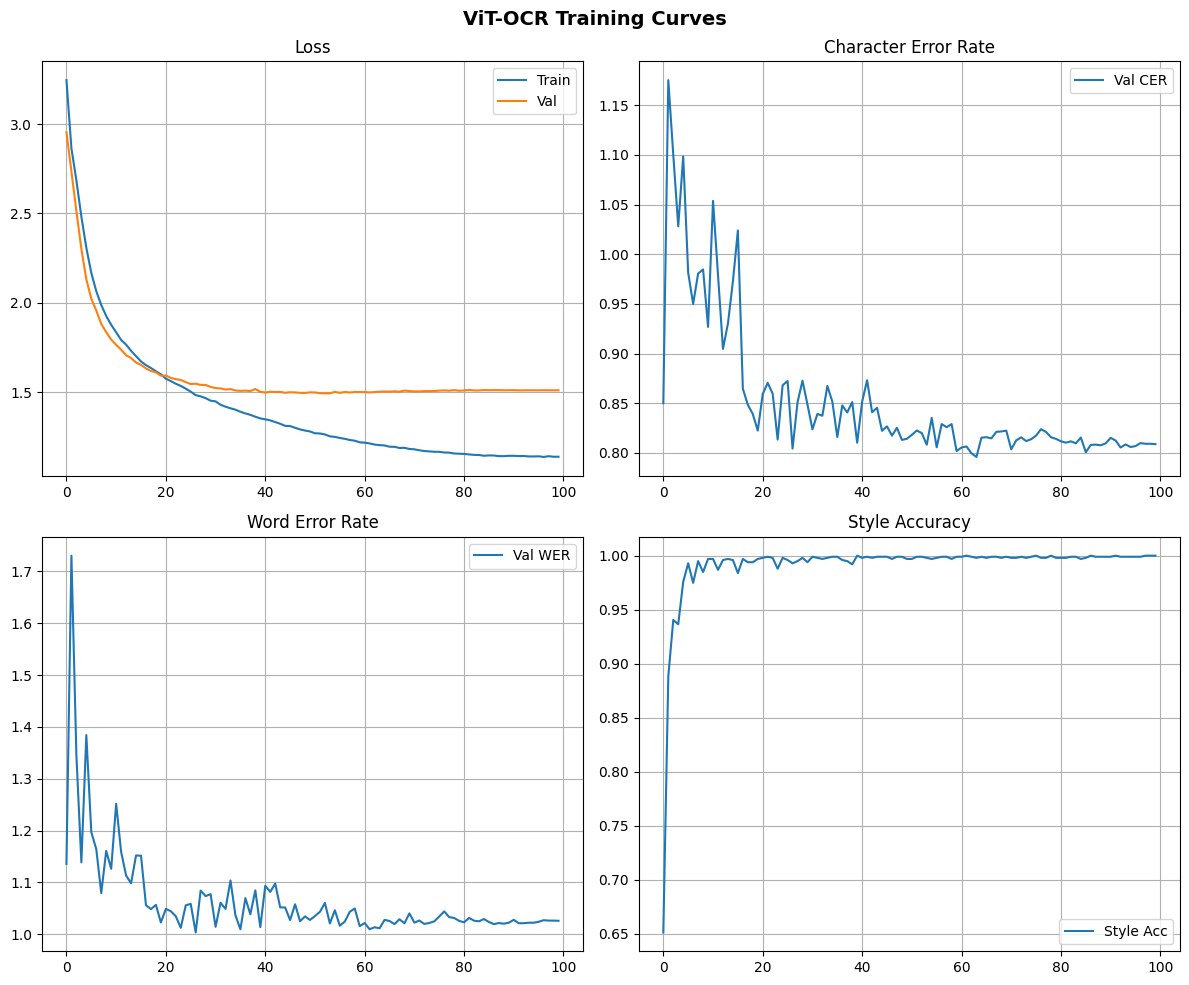


TEST EVALUATION

TEST — CER=0.8077 | WER=1.0264 | Style=1.0000

SAMPLE PREDICTIONS (Proper Arabic Display)


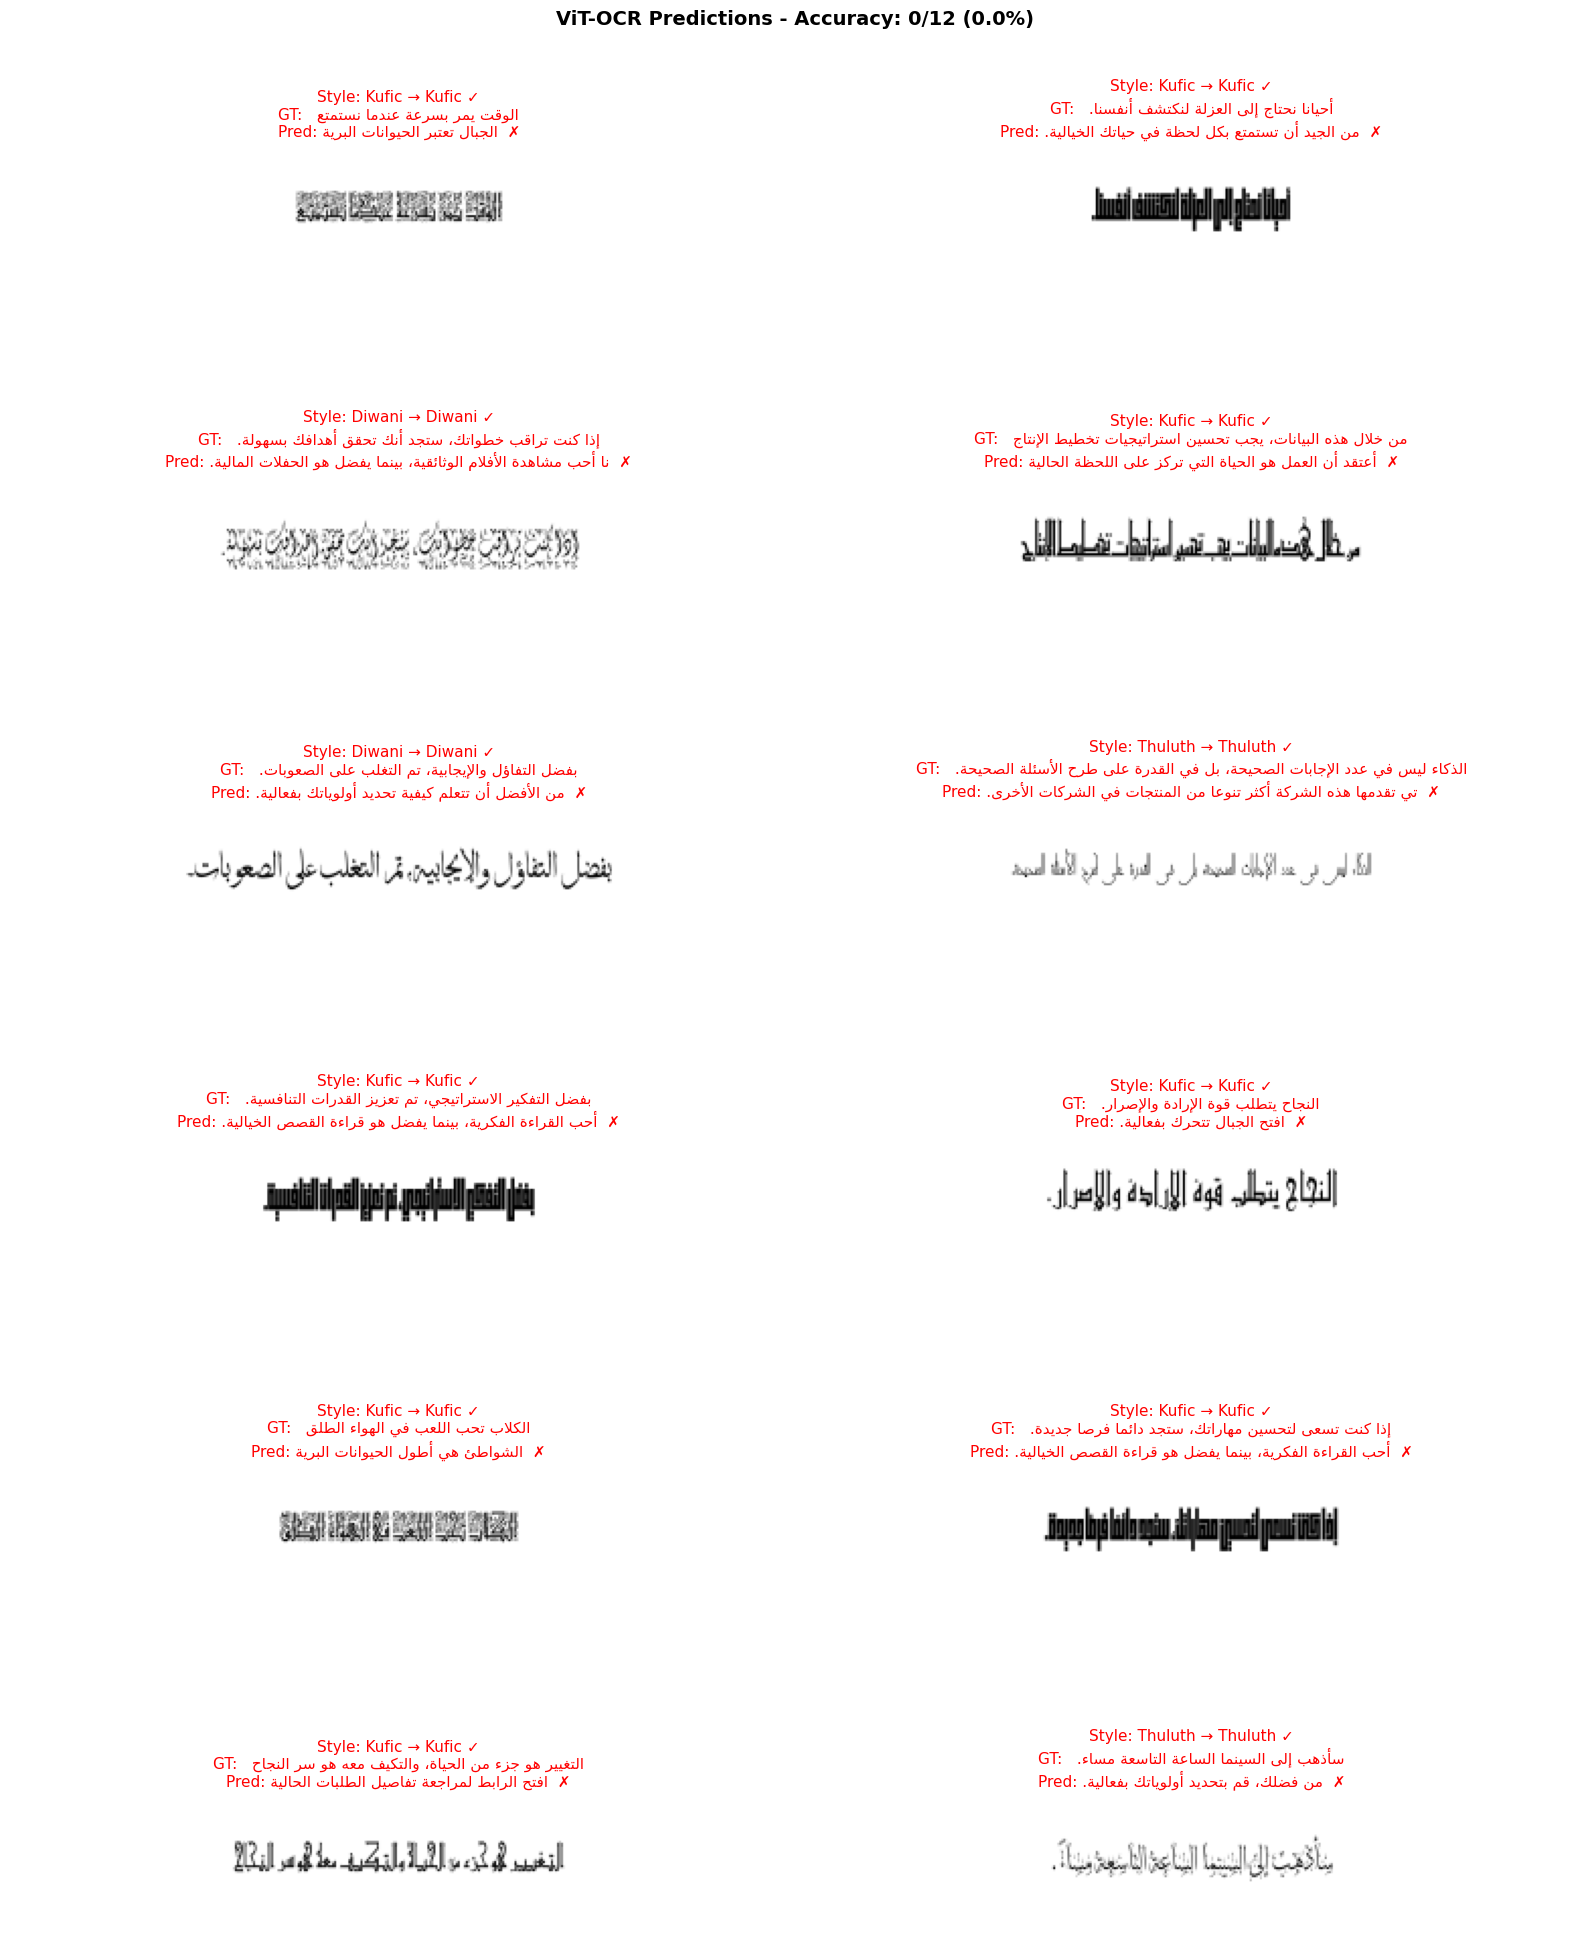


✓ Saved to checkpoints_vit/vit_samples_arabic.png
  Sample accuracy: 0/12 (0.0%)

PER-CLASS ANALYSIS


Per-class eval:   0%|          | 0/8 [00:02<?, ?it/s]


Class                CER        WER        Style Acc    Samples   
--------------------------------------------------------------
Diwani               0.7975     1.0213     1.0000       349       
Kufic                0.8165     1.0340     1.0000       371       
Thuluth              0.8088     1.0226     1.0000       272       

FINAL SUMMARY - Vision Transformer OCR
Architecture: ViT Encoder (6 layers) + Transformer Decoder (4 layers)
Embed dim: 384, Heads: 6, Patch size: 16
Total parameters: 20,399,300

Best Validation CER: 0.7959

Test Metrics:
  - CER: 0.8077
  - WER: 1.0264
  - Style Accuracy: 1.0000

Checkpoints: checkpoints_vit
✅ ViT-OCR Complete!


In [3]:
# %% DIFFERENT APPROACH - Vision Transformer + Transformer Decoder (TrOCR-style)
# ====================== Setup / Installs ======================
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

DRIVE_BASE = "/content/drive/MyDrive/Full_Dataset/Augmented_Data"
LOCAL_BASE = "/content/dataset"
os.makedirs(LOCAL_BASE, exist_ok=True)

for set_name in ["generated_data"]:
    zip_path = f"{DRIVE_BASE}/{set_name}.zip"
    extract_dir = f"{LOCAL_BASE}/{set_name}"
    if os.path.exists(zip_path) and not os.path.exists(extract_dir):
        print(f"Extracting {set_name}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(LOCAL_BASE)
        print(f"  ✓ {set_name} extracted")
    elif os.path.exists(extract_dir):
        print(f"  ✓ {set_name} already extracted")
    else:
        print(f"  ⚠ {zip_path} not found")

!pip -q install albumentations==1.4.7 editdistance==0.8.1 tqdm timm arabic-reshaper python-bidi

# ====================== Imports ======================
import time, random, unicodedata, warnings, math, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import albumentations as A
import timm

# Arabic text display imports
import arabic_reshaper
from bidi.algorithm import get_display

warnings.filterwarnings("ignore")
cv2.setNumThreads(0)

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

def human(n): return f"{n:,}"
def autocast_ctx(): return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        return f"GPU: {a:.2f}/{r:.2f}GB"
    return "CPU"

# ====================== Arabic Display Helper ======================
def format_arabic_for_display(text):
    """
    Format Arabic text for proper display:
    1. Reshape Arabic letters to connect properly
    2. Apply bidirectional algorithm for correct RTL display
    """
    try:
        reshaped = arabic_reshaper.reshape(text)
        display_text = get_display(reshaped)
        return display_text
    except:
        return text

# ====================== Data Loading ======================
LOCAL_BASE = Path("/content/dataset")
CSV_PATH = Path("/content/drive/MyDrive/Full_Dataset/Augmented_Data/labels_fixed.csv")
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
assert {'img_name', 'label', 'class'}.issubset(df.columns)

def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df['label'] = df['label'].astype(str).apply(normalize_label)

def get_img_path(img_name):
    return "/content/dataset/generated_data/" + img_name

df['img_path'] = df['img_name'].apply(get_img_path)
df = df[df['img_path'].apply(lambda p: p is not None and Path(p).exists())].reset_index(drop=True)
print(f"Images found: {human(len(df))}")

# ====================== Special Tokens & Charset ======================
PAD_TOKEN = '<PAD>'
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'

char_counts = Counter()
for s in df['label']:
    for ch in s:
        char_counts[ch] += 1

special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
char_tokens = sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
vocab = special_tokens + char_tokens

char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}

PAD_IDX = char2idx[PAD_TOKEN]
SOS_IDX = char2idx[SOS_TOKEN]
EOS_IDX = char2idx[EOS_TOKEN]
UNK_IDX = char2idx[UNK_TOKEN]
VOCAB_SIZE = len(vocab)

print(f"Vocabulary size: {VOCAB_SIZE} (incl. special tokens)")

# ====================== Style Classes ======================
style_names = sorted(df['class'].fillna("Unknown").unique().tolist())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}
NUM_STYLES = len(style_names)
print(f"Styles ({NUM_STYLES}): {style_names}")

# ====================== Encode/Decode Functions ======================
RTL_REVERSE = True
MAX_SEQ_LEN = 64

def encode_label(text, rtl_reverse=RTL_REVERSE):
    """Encode text to token indices (with SOS/EOS)."""
    if rtl_reverse:
        text = text[::-1]
    ids = [SOS_IDX] + [char2idx.get(ch, UNK_IDX) for ch in text] + [EOS_IDX]
    return ids[:MAX_SEQ_LEN]

def decode_tokens(indices, rtl_reverse=RTL_REVERSE):
    """Decode token indices back to text."""
    chars = []
    for idx in indices:
        if idx == EOS_IDX:
            break
        if idx not in [PAD_IDX, SOS_IDX, UNK_IDX]:
            chars.append(idx2char.get(idx, ''))
    text = ''.join(chars)
    return text[::-1] if rtl_reverse else text

# Filter empty labels
df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
df = df[df['enc_len'] > 2].reset_index(drop=True)
print(f"After filtering: {human(len(df))} samples")

# ====================== Train/Val/Test Split ======================
train_df, test_df = train_test_split(df, test_size=0.10, random_state=SEED, stratify=df['class'])
train_df, val_df = train_test_split(train_df, test_size=0.1111, random_state=SEED, stratify=train_df['class'])
print(f"Train: {human(len(train_df))} | Val: {human(len(val_df))} | Test: {human(len(test_df))}")

# ====================== Class Balancing ======================
train_class_counts = train_df['class'].value_counts()
median_count = train_class_counts.median()
class_weights = {}
for cls, count in train_class_counts.items():
    weight = np.sqrt(median_count / count)
    weight = np.clip(weight, 1.0, 8.0)
    class_weights[cls] = weight

sample_weights = train_df['class'].map(class_weights).values
sample_weights = torch.DoubleTensor(sample_weights)
effective_total = int(sum(count * class_weights[cls] for cls, count in train_class_counts.items()))
print(f"Effective samples/epoch: {effective_total}")

# ====================== Image Processing ======================
IMG_HEIGHT = 64
IMG_WIDTH = 384
MEAN, STD = 0.5, 0.5
PATCH_SIZE = 16

def load_and_preprocess(img_path, target_h=IMG_HEIGHT, target_w=IMG_WIDTH):
    """Load image, resize maintaining aspect ratio, pad to fixed size."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = np.ones((target_h, target_w), dtype=np.uint8) * 255

    h, w = img.shape
    scale = target_h / h
    new_w = int(w * scale)
    new_w = min(new_w, target_w)

    img = cv2.resize(img, (new_w, target_h), interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC)

    if new_w < target_w:
        pad_w = target_w - new_w
        img = cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=255)

    return img

# ====================== Augmentations ======================
AUG_P = 0.35

train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P * 0.8),
    A.Perspective(scale=(0.02, 0.05), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=2, border_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P * 0.8),
    A.GaussianBlur(blur_limit=(3, 5), p=AUG_P * 0.4),
])

def apply_aug(img):
    return train_aug(image=img)["image"]

# ====================== Dataset ======================
class OCRSeq2SeqDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, training=True):
        self.df = frame.reset_index(drop=True)
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]

        img = load_and_preprocess(row['img_path'], IMG_HEIGHT, IMG_WIDTH)

        if self.training:
            img = apply_aug(img)

        img = img.astype(np.float32) / 255.0
        img = (img - MEAN) / STD
        img_t = torch.from_numpy(img).unsqueeze(0)

        label_ids = encode_label(row['label'], RTL_REVERSE)
        label_t = torch.tensor(label_ids, dtype=torch.long)

        style_idx = style2idx[row['class']]

        return img_t, label_t, row['label'], style_idx

def collate_fn(batch):
    imgs, labels, label_strs, style_idxs = zip(*batch)

    imgs = torch.stack(imgs, dim=0)
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=PAD_IDX)
    style_idxs = torch.tensor(style_idxs, dtype=torch.long)

    return imgs, labels_padded, label_lens, label_strs, style_idxs

# ====================== Vision Transformer Encoder ======================
class PatchEmbedding(nn.Module):
    """Convert image to patch embeddings."""
    def __init__(self, img_h=64, img_w=384, patch_size=16, in_chans=1, embed_dim=384):
        super().__init__()
        self.img_h = img_h
        self.img_w = img_w
        self.patch_size = patch_size
        self.n_patches_h = img_h // patch_size
        self.n_patches_w = img_w // patch_size
        self.n_patches = self.n_patches_h * self.n_patches_w

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class ViTEncoder(nn.Module):
    """Vision Transformer Encoder."""
    def __init__(self, img_h=64, img_w=384, patch_size=16, in_chans=1,
                 embed_dim=384, depth=6, num_heads=6, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_h, img_w, patch_size, in_chans, embed_dim)
        n_patches = self.patch_embed.n_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.encoder(x)
        x = self.norm(x)
        return x

# ====================== Transformer Decoder ======================
class TransformerDecoder(nn.Module):
    """Transformer Decoder for autoregressive text generation."""
    def __init__(self, vocab_size, embed_dim=384, depth=4, num_heads=6,
                 mlp_ratio=4.0, dropout=0.1, max_seq_len=64):
        super().__init__()

        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len

        self.token_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))
        self.embed_drop = nn.Dropout(dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)

        self.output_proj = nn.Linear(embed_dim, vocab_size)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        B, T = tgt.shape

        x = self.token_embed(tgt)
        x = x + self.pos_embed[:, :T, :]
        x = self.embed_drop(x)

        if tgt_mask is None:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(T, device=tgt.device)

        x = self.decoder(x, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        x = self.norm(x)

        logits = self.output_proj(x)
        return logits

# ====================== Full Model ======================
class VisionTransformerOCR(nn.Module):
    """
    TrOCR-style model:
    - ViT Encoder for image features
    - Transformer Decoder for autoregressive text generation
    - Style classification head
    """
    def __init__(self, vocab_size, num_styles, img_h=64, img_w=384, patch_size=16,
                 embed_dim=384, enc_depth=6, dec_depth=4, num_heads=6,
                 mlp_ratio=4.0, dropout=0.1, max_seq_len=64):
        super().__init__()

        self.encoder = ViTEncoder(
            img_h=img_h, img_w=img_w, patch_size=patch_size, in_chans=1,
            embed_dim=embed_dim, depth=enc_depth, num_heads=num_heads,
            mlp_ratio=mlp_ratio, dropout=dropout
        )

        self.decoder = TransformerDecoder(
            vocab_size=vocab_size, embed_dim=embed_dim, depth=dec_depth,
            num_heads=num_heads, mlp_ratio=mlp_ratio, dropout=dropout,
            max_seq_len=max_seq_len
        )

        self.style_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_styles)
        )

        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len

    def forward(self, imgs, tgt_ids=None, tgt_padding_mask=None):
        memory = self.encoder(imgs)
        style_logits = self.style_head(memory.mean(dim=1))

        if tgt_ids is not None:
            logits = self.decoder(tgt_ids, memory, tgt_key_padding_mask=tgt_padding_mask)
            return logits, style_logits
        else:
            return memory, style_logits

    @torch.no_grad()
    def generate(self, imgs, max_len=None, temperature=1.0):
        """Autoregressive generation."""
        if max_len is None:
            max_len = self.max_seq_len

        B = imgs.size(0)
        device = imgs.device

        memory = self.encoder(imgs)

        generated = torch.full((B, 1), SOS_IDX, dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            logits = self.decoder(generated, memory)
            next_logits = logits[:, -1, :] / temperature

            next_token = next_logits.argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)

            if (next_token == EOS_IDX).all():
                break

        return generated

# ====================== Training Configuration ======================
BATCH_SIZE = 128
EPOCHS = 100
LR = 3e-4
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 5
LABEL_SMOOTHING = 0.1
LAMBDA_STYLE = 0.15

sampler = WeightedRandomSampler(sample_weights, num_samples=effective_total, replacement=True)

# ====================== Dataloaders ======================
train_ds = OCRSeq2SeqDataset(train_df, training=True)
val_ds = OCRSeq2SeqDataset(val_df, training=False)
test_ds = OCRSeq2SeqDataset(test_df, training=False)

NUM_WORKERS = 4
loader_kwargs = dict(collate_fn=collate_fn, pin_memory=True, num_workers=NUM_WORKERS, persistent_workers=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, **loader_kwargs)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)

print(f"\nTrain loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")

# ====================== Model ======================
print("\n" + "="*60)
print("MODEL ARCHITECTURE - Vision Transformer OCR")
print("="*60)

model = VisionTransformerOCR(
    vocab_size=VOCAB_SIZE,
    num_styles=NUM_STYLES,
    img_h=IMG_HEIGHT,
    img_w=IMG_WIDTH,
    patch_size=PATCH_SIZE,
    embed_dim=384,
    enc_depth=6,
    dec_depth=4,
    num_heads=6,
    mlp_ratio=4.0,
    dropout=0.1,
    max_seq_len=MAX_SEQ_LEN
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {human(total_params)}")

# ====================== Loss & Optimizer ======================
ce_loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=LABEL_SMOOTHING)
style_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.98))

def get_lr(epoch):
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / WARMUP_EPOCHS
    else:
        progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, get_lr)
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE == "cuda"))

# ====================== Metrics ======================
def cer(ref, hyp):
    return 0.0 if (len(ref) == 0 and len(hyp) == 0) else editdistance.eval(ref, hyp) / max(1, len(ref))

def wer(ref, hyp):
    r, h = ref.split(), hyp.split()
    return 0.0 if (len(r) == 0 and len(h) == 0) else editdistance.eval(r, h) / max(1, len(r))

# ====================== Evaluation ======================
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    tot_loss = tot_cer = tot_wer = 0.0
    cnt = 0
    cls_correct = cls_total = 0

    for imgs, labels, label_lens, label_strs, style_idxs in loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        B = imgs.size(0)

        tgt_padding_mask = (labels == PAD_IDX)

        with autocast_ctx():
            logits, style_logits = model(imgs, labels[:, :-1], tgt_padding_mask[:, :-1])

            loss_ce = ce_loss_fn(logits.reshape(-1, VOCAB_SIZE), labels[:, 1:].reshape(-1))
            loss_style = style_loss_fn(style_logits, style_idxs)
            loss = loss_ce + LAMBDA_STYLE * loss_style

        tot_loss += loss.item() * B
        cnt += B

        generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
        preds = [decode_tokens(gen.tolist()) for gen in generated]

        for gt, pr in zip(label_strs, preds):
            tot_cer += cer(gt, pr)
            tot_wer += wer(gt, pr)

        pred_style = style_logits.argmax(dim=1)
        cls_correct += (pred_style == style_idxs).sum().item()
        cls_total += B

    return {
        "loss": tot_loss / cnt if cnt else None,
        "cer": tot_cer / cnt if cnt else None,
        "wer": tot_wer / cnt if cnt else None,
        "style_acc": cls_correct / cls_total if cls_total > 0 else None
    }

# ====================== Training Loop ======================
print("\n" + "="*60)
print("TRAINING - Vision Transformer OCR")
print("="*60)

SAVE_DIR = Path("./checkpoints_vit")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "vit_ocr_best.pt"

history = {"train_loss": [], "val_loss": [], "val_cer": [], "val_wer": [], "val_style_acc": []}
best_cer = float('inf')

print(f"\n[Training] Epochs={EPOCHS}, Batch={BATCH_SIZE}, LR={LR}")
print(f"Device: {DEVICE} | {gpu_mem()}\n")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    seen = 0
    t0 = time.time()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch:03d}", leave=False)
    for bidx, (imgs, labels, label_lens, label_strs, style_idxs) in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        tgt_padding_mask = (labels == PAD_IDX)

        optimizer.zero_grad(set_to_none=True)

        with autocast_ctx():
            logits, style_logits = model(imgs, labels[:, :-1], tgt_padding_mask[:, :-1])

            loss_ce = ce_loss_fn(logits.reshape(-1, VOCAB_SIZE), labels[:, 1:].reshape(-1))
            loss_style = style_loss_fn(style_logits, style_idxs)
            loss = loss_ce + LAMBDA_STYLE * loss_style

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(loss=f"{loss.item():.3f}", avg=f"{running/max(1,seen):.3f}")

    scheduler.step()
    train_loss = running / max(1, seen)
    history["train_loss"].append(train_loss)

    # Validation
    val_metrics = evaluate(model, val_loader)
    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

    dt = time.time() - t0
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:03d}/{EPOCHS} | train={train_loss:.3f} | "
          f"val: CER={val_metrics['cer']:.4f} WER={val_metrics['wer']:.4f} style={val_metrics['style_acc']:.3f} | "
          f"lr={current_lr:.2e} | {dt:.1f}s | {gpu_mem()}")

    # Save best model
    if val_metrics["cer"] is not None and val_metrics["cer"] < best_cer:
        best_cer = val_metrics["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "vocab": vocab,
            "char2idx": char2idx,
            "style_names": style_names,
            "config": {
                "IMG_HEIGHT": IMG_HEIGHT, "IMG_WIDTH": IMG_WIDTH,
                "RTL_REVERSE": RTL_REVERSE, "MAX_SEQ_LEN": MAX_SEQ_LEN
            },
            "metrics": val_metrics
        }, BEST_PATH)
        print(f"  ✓ New best CER={best_cer:.4f} saved")

    if epoch % 10 == 0:
        gc.collect()
        torch.cuda.empty_cache()

print(f"\n[Training] Complete! Best CER: {best_cer:.4f}")

# ====================== Training Curves ======================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss"); axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer"], label="Val CER")
axes[0, 1].set_title("Character Error Rate"); axes[0, 1].legend(); axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer"], label="Val WER")
axes[1, 0].set_title("Word Error Rate"); axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc"], label="Style Acc")
axes[1, 1].set_title("Style Accuracy"); axes[1, 1].legend(); axes[1, 1].grid(True)

plt.suptitle("ViT-OCR Training Curves", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(SAVE_DIR / "training_curves.png", dpi=150)
plt.show()

# ====================== Test Evaluation ======================
print("\n" + "="*60)
print("TEST EVALUATION")
print("="*60)

ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

test_metrics = evaluate(model, test_loader)
print(f"\nTEST — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | Style={test_metrics['style_acc']:.4f}")

# ====================== Qualitative Samples (Proper Arabic Display) ======================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS (Proper Arabic Display)")
print("="*60)

plt.rcParams['font.family'] = 'DejaVu Sans'

@torch.no_grad()
def show_samples_arabic(model, loader, k=12):
    """Display sample predictions with proper Arabic text rendering."""
    model.eval()
    imgs, labels, label_lens, label_strs, style_idxs = next(iter(loader))
    imgs = imgs.to(DEVICE)
    style_idxs = style_idxs.to(DEVICE)

    generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
    preds = [decode_tokens(gen.tolist()) for gen in generated]

    _, style_logits = model(imgs, labels[:, :-1].to(DEVICE))
    style_pred = style_logits.argmax(1).cpu().tolist()

    n_samples = min(k, len(imgs))
    n_cols = 2
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
    axes = axes.flatten() if n_samples > 1 else [axes]

    correct = 0
    total = 0

    for i in range(n_samples):
        im = imgs[i, 0].cpu().numpy()
        im = np.clip(im * STD + MEAN, 0, 1)

        gt_style = idx2style[style_idxs[i].item()]
        pr_style = idx2style[style_pred[i]]
        gt_text = label_strs[i]
        pr_text = preds[i]

        # Format for proper Arabic display
        gt_display = format_arabic_for_display(gt_text)
        pr_display = format_arabic_for_display(pr_text)

        match = gt_text == pr_text
        if match:
            correct += 1
        total += 1

        match_symbol = "✓" if match else "✗"
        match_color = "green" if match else "red"
        style_match = "✓" if gt_style == pr_style else "✗"

        axes[i].imshow(im, cmap='gray')
        axes[i].axis('off')

        title = f"Style: {gt_style} → {pr_style} {style_match}\n"
        title += f"GT:   {gt_display}\n"
        title += f"Pred: {pr_display}  {match_symbol}"

        axes[i].set_title(title, fontsize=11, color=match_color if not match else 'black',
                         fontfamily='DejaVu Sans', ha='center')

    # Hide unused axes
    for i in range(n_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f"ViT-OCR Predictions - Accuracy: {correct}/{total} ({100*correct/total:.1f}%)",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(SAVE_DIR / "vit_samples_arabic.png", dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved to {SAVE_DIR / 'vit_samples_arabic.png'}")
    print(f"  Sample accuracy: {correct}/{total} ({100*correct/total:.1f}%)")

show_samples_arabic(model, test_loader, k=12)

# ====================== Per-Class Analysis ======================
print("\n" + "="*60)
print("PER-CLASS ANALYSIS")
print("="*60)

from collections import defaultdict

@torch.no_grad()
def per_class_evaluation(model, loader):
    model.eval()
    class_metrics = defaultdict(lambda: {"cer": [], "wer": [], "correct": 0, "total": 0})

    for imgs, labels, label_lens, label_strs, style_idxs in tqdm(loader, desc="Per-class eval"):
        imgs = imgs.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
        preds = [decode_tokens(gen.tolist()) for gen in generated]

        _, style_logits = model(imgs, labels[:, :-1].to(DEVICE))
        pred_style = style_logits.argmax(dim=1)

        for i, (gt, pr, gt_style_idx, pr_style_idx) in enumerate(
            zip(label_strs, preds, style_idxs.cpu(), pred_style.cpu())):

            cls_name = idx2style[gt_style_idx.item()]
            c = cer(gt, pr)
            w = wer(gt, pr)
            class_metrics[cls_name]["cer"].append(c)
            class_metrics[cls_name]["wer"].append(w)
            class_metrics[cls_name]["total"] += 1
            if gt_style_idx == pr_style_idx:
                class_metrics[cls_name]["correct"] += 1

    return class_metrics

class_results = per_class_evaluation(model, test_loader)

print(f"\n{'Class':<20} {'CER':<10} {'WER':<10} {'Style Acc':<12} {'Samples':<10}")
print("-" * 62)
for cls_name in sorted(class_results.keys()):
    m = class_results[cls_name]
    avg_cer = np.mean(m["cer"])
    avg_wer = np.mean(m["wer"])
    style_acc = m["correct"] / m["total"] if m["total"] > 0 else 0
    print(f"{cls_name:<20} {avg_cer:<10.4f} {avg_wer:<10.4f} {style_acc:<12.4f} {m['total']:<10}")

# ====================== Final Summary ======================
print("\n" + "="*60)
print("FINAL SUMMARY - Vision Transformer OCR")
print("="*60)
print(f"Architecture: ViT Encoder (6 layers) + Transformer Decoder (4 layers)")
print(f"Embed dim: 384, Heads: 6, Patch size: {PATCH_SIZE}")
print(f"Total parameters: {human(total_params)}")
print(f"\nBest Validation CER: {best_cer:.4f}")
print(f"\nTest Metrics:")
print(f"  - CER: {test_metrics['cer']:.4f}")
print(f"  - WER: {test_metrics['wer']:.4f}")
print(f"  - Style Accuracy: {test_metrics['style_acc']:.4f}")
print(f"\nCheckpoints: {SAVE_DIR}")
print("✅ ViT-OCR Complete!")

## RESULTS VISUALIZATION


DETAILED VISUAL ANALYSIS (TEST SET)


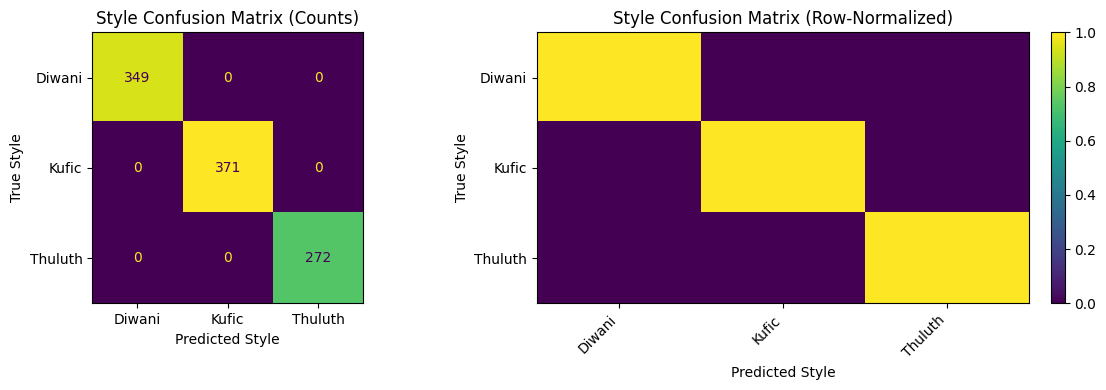

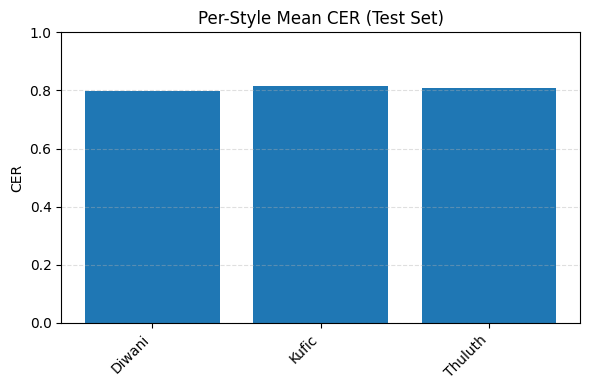

Per-style mean CER:
  Diwani   -> 0.7975
  Kufic    -> 0.8165
  Thuluth  -> 0.8088


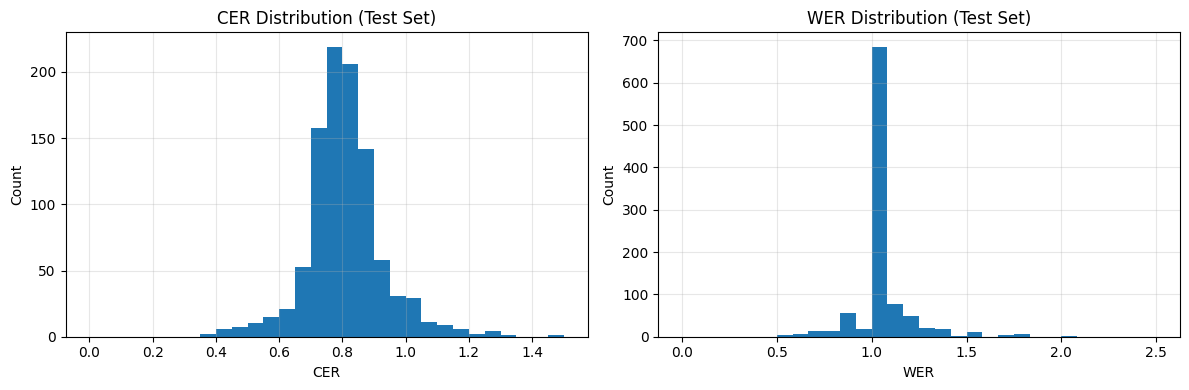

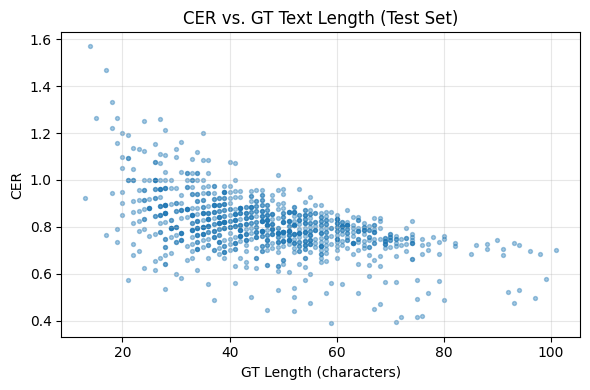


Summary (Test Set Distributions):
  CER  -> mean=0.8077, median=0.8000
  WER  -> mean=1.0264, median=1.0000
  Len  -> mean=46.55, median=46.00
✅ Visual analysis complete.


In [5]:
# %% VISUAL ANALYSIS: CONFUSION MATRIX & ERROR DISTRIBUTIONS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import defaultdict

print("\n" + "="*60)
print("DETAILED VISUAL ANALYSIS (TEST SET)")
print("="*60)

@torch.no_grad()
def collect_test_stats(model, loader):
    """
    Collect statistics on the test set for the ViT+TransformerDecoder model.

    Uses:
      - model.generate(...) for sequence predictions
      - model(imgs, labels[:, :-1]) for style logits
    """
    model.eval()
    all_style_true = []
    all_style_pred = []
    cer_list = []
    wer_list = []
    len_list = []
    examples = []  # store a few example tuples for potential later visualization

    for imgs, labels, label_lens, label_strs, style_idxs in loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)

        # --- Text predictions ---
        generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
        preds = [decode_tokens(gen.tolist()) for gen in generated]

        # --- Style predictions ---
        _, style_logits = model(imgs, labels[:, :-1])
        style_hat = style_logits.argmax(dim=1)

        for i in range(len(label_strs)):
            gt = label_strs[i]
            pr = preds[i]

            c = cer(gt, pr)
            w = wer(gt, pr)
            cer_list.append(c)
            wer_list.append(w)
            len_list.append(len(gt))

            s_true = int(style_idxs[i].item())
            s_pred = int(style_hat[i].item())
            all_style_true.append(s_true)
            all_style_pred.append(s_pred)

            # Keep a few sample examples
            if len(examples) < 50:
                examples.append({
                    "img": imgs[i, 0].detach().cpu().numpy(),
                    "gt": gt,
                    "pred": pr,
                    "style_true": idx2style[s_true],
                    "style_pred": idx2style[s_pred],
                    "cer": c,
                    "wer": w,
                })

    stats = {
        "style_true": all_style_true,
        "style_pred": all_style_pred,
        "cer": np.array(cer_list),
        "wer": np.array(wer_list),
        "lengths": np.array(len_list),
        "examples": examples,
    }
    return stats


stats = collect_test_stats(model, test_loader)

# ---------- STYLE CONFUSION MATRIX ----------
cm = confusion_matrix(
    stats["style_true"],
    stats["style_pred"],
    labels=list(range(len(style_names)))
)

fig_cm, ax_cm = plt.subplots(1, 2, figsize=(12, 4))

# Raw counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=style_names)
disp.plot(ax=ax_cm[0], colorbar=False)
ax_cm[0].set_title("Style Confusion Matrix (Counts)")
ax_cm[0].set_xlabel("Predicted Style")
ax_cm[0].set_ylabel("True Style")

# Normalized per row (true style)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1)
im = ax_cm[1].imshow(cm_norm, aspect='auto')
ax_cm[1].set_xticks(range(len(style_names)))
ax_cm[1].set_yticks(range(len(style_names)))
ax_cm[1].set_xticklabels(style_names, rotation=45, ha='right')
ax_cm[1].set_yticklabels(style_names)
ax_cm[1].set_title("Style Confusion Matrix (Row-Normalized)")
ax_cm[1].set_xlabel("Predicted Style")
ax_cm[1].set_ylabel("True Style")
fig_cm.colorbar(im, ax=ax_cm[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# ---------- PER-STYLE MEAN CER ----------
style_cer = {s: [] for s in style_names}
for s_idx, c in zip(stats["style_true"], stats["cer"]):
    style_cer[idx2style[s_idx]].append(c)

style_mean_cer = {
    s: (np.mean(v) if len(v) > 0 else np.nan)
    for s, v in style_cer.items()
}

fig_style, ax_style = plt.subplots(figsize=(6, 4))
ax_style.bar(list(style_mean_cer.keys()), list(style_mean_cer.values()))
ax_style.set_title("Per-Style Mean CER (Test Set)")
ax_style.set_ylabel("CER")
ax_style.set_ylim(0, 1.0)
for tick in ax_style.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')
ax_style.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("Per-style mean CER:")
for s, v in style_mean_cer.items():
    print(f"  {s:8s} -> {v:.4f}")

# ---------- CER / WER HISTOGRAMS ----------
fig_hist, axes_hist = plt.subplots(1, 2, figsize=(12, 4))

axes_hist[0].hist(stats["cer"], bins=30, range=(0, 1.5))
axes_hist[0].set_title("CER Distribution (Test Set)")
axes_hist[0].set_xlabel("CER")
axes_hist[0].set_ylabel("Count")
axes_hist[0].grid(alpha=0.3)

axes_hist[1].hist(stats["wer"], bins=30, range=(0, 2.5))
axes_hist[1].set_title("WER Distribution (Test Set)")
axes_hist[1].set_xlabel("WER")
axes_hist[1].set_ylabel("Count")
axes_hist[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- CER vs WORD LENGTH ----------
fig_len, ax_len = plt.subplots(figsize=(6, 4))
ax_len.scatter(stats["lengths"], stats["cer"], s=8, alpha=0.4)
ax_len.set_title("CER vs. GT Text Length (Test Set)")
ax_len.set_xlabel("GT Length (characters)")
ax_len.set_ylabel("CER")
ax_len.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSummary (Test Set Distributions):")
print(f"  CER  -> mean={stats['cer'].mean():.4f}, median={np.median(stats['cer']):.4f}")
print(f"  WER  -> mean={stats['wer'].mean():.4f}, median={np.median(stats['wer']):.4f}")
print(f"  Len  -> mean={stats['lengths'].mean():.2f}, median={np.median(stats['lengths']):.2f}")
print("✅ Visual analysis complete.")
